# loading

In [3]:
import os
import struct
import random
import numpy as np
import matplotlib.pyplot as plt

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels.idx1-ubyte'
                                % kind)
    images_path = os.path.join(path,
                               '%s-images.idx3-ubyte'
                               % kind)

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII",
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

#### Loading the data

X_train, y_train = load_mnist('./data', kind='train')
X_test, y_test = load_mnist('./data', kind='t10k')

In [4]:
print('train_sample_number:\t:%d, column_number:%d' %(X_train.shape[0], X_train.shape[1]))
print('test_sample_number\t:%d, column_number:%d' %(X_test.shape[0], X_test.shape[1]))

train_sample_number:	:60000, column_number:784
test_sample_number	:10000, column_number:784


# preprocessing

In [5]:
X_train=X_train/255
X_test=X_test/255

# classifer

In [87]:
class myClassifier(object):
    """
    ovr
    """
    def __init__(self, C=0.1, eta=0.001, batch_size=500, num_iter=25, epsilon=0.001, class_num=0, shuffle=True):
        self.C=C
        self.eta=eta
        self.batch_size=batch_size
        self.num_iter=num_iter
        self.epsilon=epsilon
        self.class_num=class_num
        self.shuffle=shuffle
        
    def fit(self, X, y):
        X_num, X_fea = np.shape(X)
        #X_num=60000 X_fea=28*28
        self.class_num=len(np.unique(y))
        #class_num=10
        
        w=np.random.rand(self.class_num,X_fea)
        #w=[class_num][28*28]
        aver_w=w
        b=np.random.rand(self.class_num,1)
        #b=[class_num][1]
        aver_b=b
        
        if self.shuffle:
            s_data, s_labels = self.shuffling(X, y)
            #s_data[60000][28*28]
            #s_labels[60000][1]
        
        encoded_y=self.encoding(s_labels)
        #encoded_y[60000][class_num]
        
        cnt=0
        batch_count=X_num/self.batch_size
        for Xi in range(self.num_iter):
            #minibatch training
            for t in range(int(batch_count)):
                ###sgd
                batch_X, batch_y, bs=self.batching(s_data, encoded_y, t)
                #batch_X[batch_size][784] batch_y[batch_size][class_num] last_size=?
                
                batch_X=np.reshape(batch_X,(bs,X_fea))
                batch_y=np.reshape(batch_y,(bs,self.class_num))
                
                delta_w=np.zeros((self.class_num,X_fea))
                #delta_w[class_num][28*28]
                delta_b=np.zeros((self.class_num,1))
                #delta_b[10][1]
                
                loss=self.hinge_loss(batch_X, batch_y, w, b)
                #loss[batch_size][class_num]
                loss=1-loss-self.epsilon
                
                loss[loss<0]=1
                loss[loss>=0]=0
                
                l_M_y=loss*batch_y
                #l_M_y  =loss[bs][class_num] batch_y[bs][class_num]
                
                temp_w=np.dot(np.transpose(l_M_y),batch_X)
                #temp_w[10][28*28]=batch_y[batch_size][28*28]
                delta_w=-(1/bs)*np.array(temp_w)+(1/self.C)*np.array(w)
                #delta_w[10][28*28]=c*temp_w[10][28*28]+c*w[10][28*28]
                
                temp_b=np.sum(np.transpose(l_M_y),axis=1)
                temp_b=np.reshape(temp_b,(self.class_num,1))
                #temp_b[class_num][1]
                delta_b=-(1/bs) * temp_b
                #delta_b[10][1]=c*[class_num][1]
                cnt+=1
            ###algorism
            
            w=np.array(w)-(self.eta*delta_w)
            #w[class_num][28*28]
            b=np.subtract(b,(self.eta * delta_b))
            #b[class_num][1]
            
            temp2_w=(cnt/cnt+1)*aver_w + (1/cnt+1)*w
            temp2_b=(cnt/cnt+1)*aver_b + (1/cnt+1)*b
            
            aver_w=np.where(aver_w>temp2_w,aver_w,temp2_w)
            aver_b=np.where(aver_b>temp2_b,aver_b,temp2_b)
            
        return aver_w, aver_b
           
    def encoding(self, y):
        encoded_y=-1*np.ones((np.shape(y)[0],self.class_num))
        #encoded_y[60000][class_num]
        for i in range(np.shape(y)[0]):
            encoded_y[i,y[i]] = 1
        return encoded_y
                
    def shuffling(self, X, y):
        temp_s=list(zip(X,y))
        random.shuffle(temp_s)
        X,y=zip(*temp_s)
        return X,y
    
    def batching(self, X, y, t):                         
        batch_X=X[t*self.batch_size:min(len(X),(t+1)*self.batch_size)]
        #batch_X[batch_size][28*28]
        batch_y=y[t*self.batch_size:min(len(X),(t+1)*self.batch_size)]
        #batch_y[batch_size][class_num]
        last_size=min(len(X), (t+1)*self.batch_size)-t*self.batch_size
        #last_size[size][28*28]
        
        return batch_X, batch_y,last_size
    
    def hinge_loss(self, X, y, w, b):
        net_v=self.net_input(X,w)
        #net_v[batch_size][class_num]
        temp_l=np.array(net_v)+np.transpose(b)
        #temp_l[batch_size][class_num]
        loss=y*temp_l
        #loss[batch_size][class_num]
        return loss
    
    def net_input(self, X, w):
        #X[batch_size][28*28] w[class_num][28*28]
        net=np.dot(X,np.transpose(w))
        #[batch_size][class_num]
        return net
                      
    def test(self,X,y,w,b):
        net_v=self.net_input(X,w)
        #net_v[batch_size][class_num]
        temp_t=np.array(net_v)+np.transpose(b)
        #temp_t[batch_size][class_num]
        correct=0
        #self.img
        for i in range(len(X)):
            p=np.argmax(temp_t,axis=1)[i]
            print(p)
            c=self.img(i,X,y,p)
            correct+=c
        return correct
    
    def img(self, row, X, y, p):
        image = np.zeros((28,28))
        for i in range(0,28):
            for j in range(0,28):
                pix = 28*i+j
                image[i,j] = X[row, pix]
        plt.imshow(image, cmap = 'gray')
        plt.title('%d)true_value: %d pridicted_value: %d' %(row+1, y[row], p))
        plt.show()
        if p==y[row]:
            c=0
        else :
            c=1
        return c

In [88]:
mine=myClassifier()
w,b=mine.fit(X_test, y_test)

6


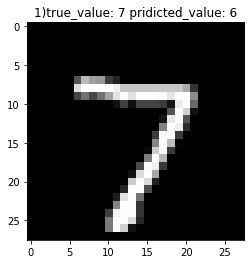

2


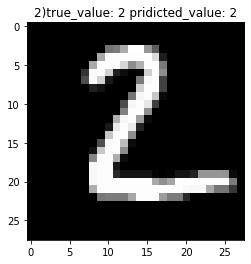

0


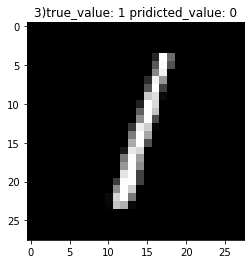

5


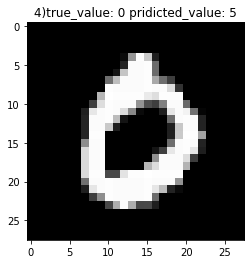

7


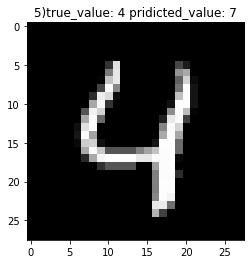

5


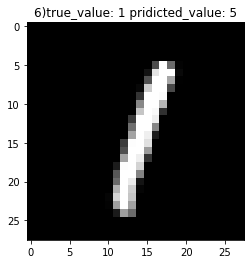

5


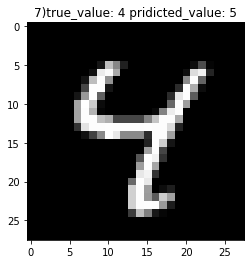

2


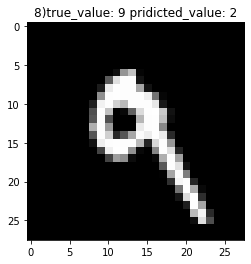

6


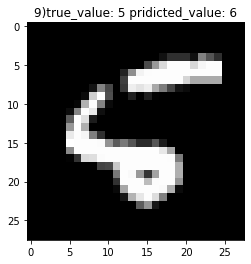

6


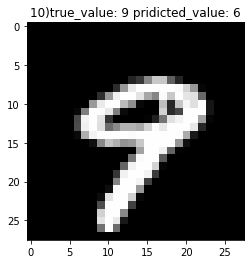

5


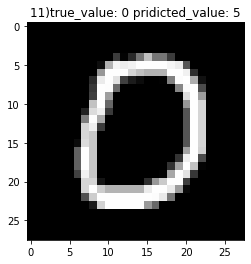

0


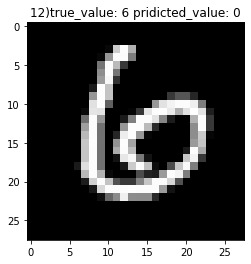

6


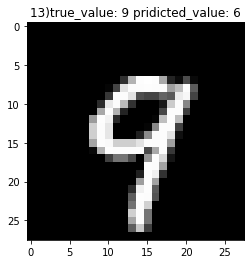

0


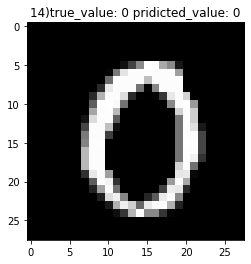

2


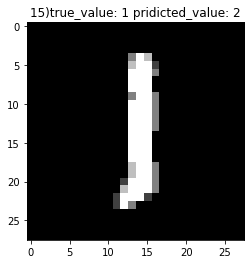

5


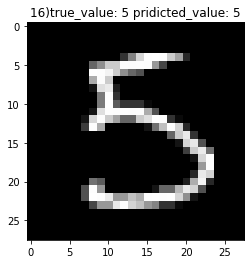

0


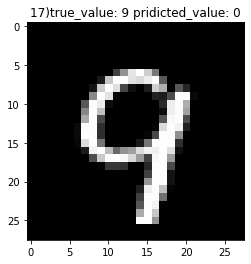

5


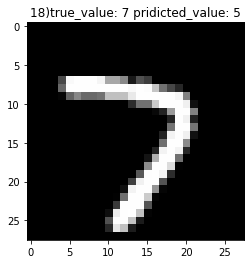

5


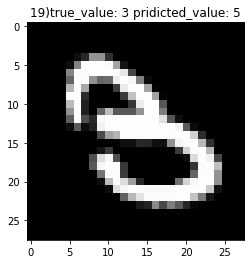

2


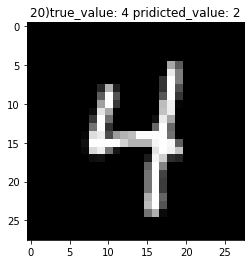

0


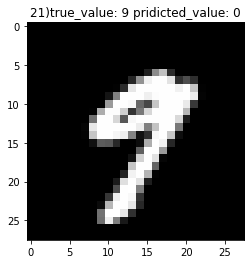

0


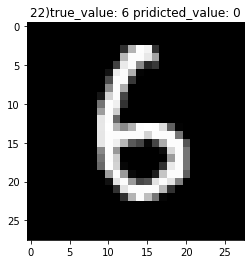

5


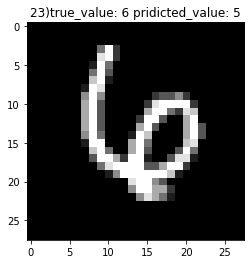

6


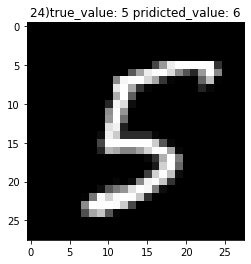

0


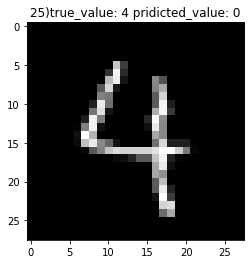

5


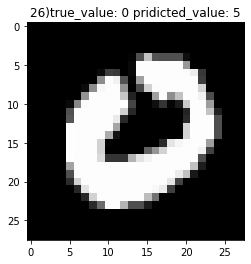

7


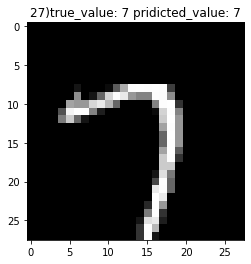

6


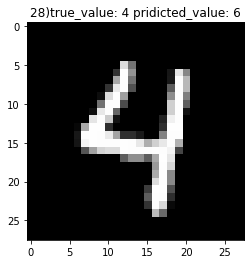

0


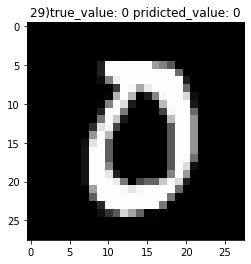

5


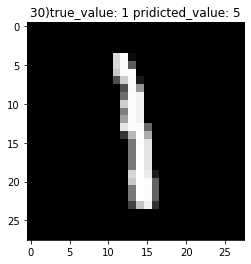

0


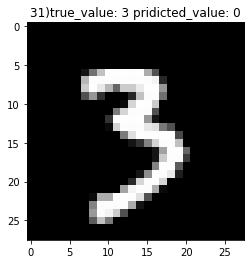

2


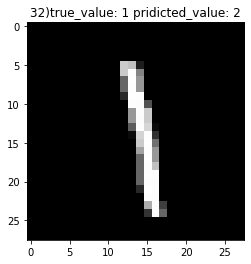

5


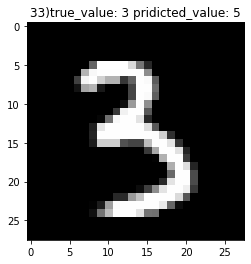

7


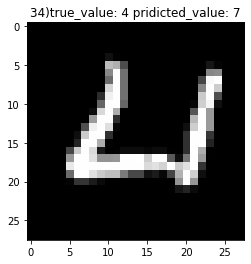

0


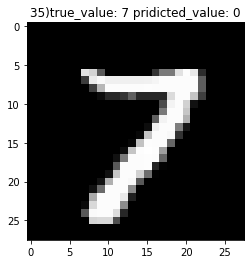

5


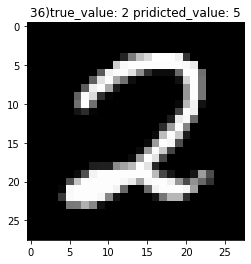

0


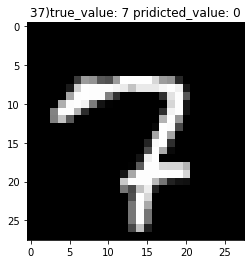

2


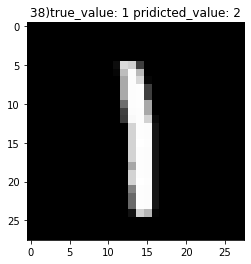

5


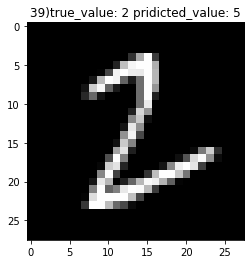

5


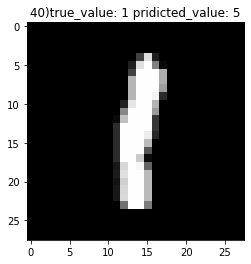

2


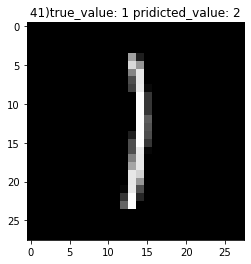

0


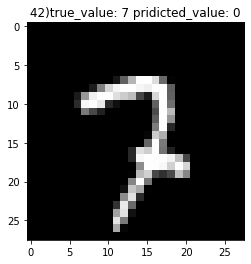

5


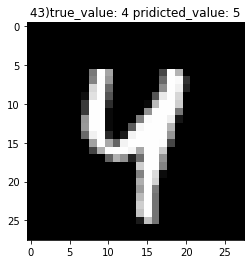

5


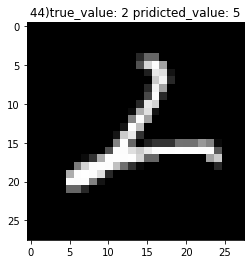

5


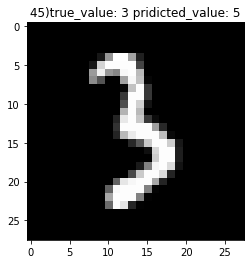

6


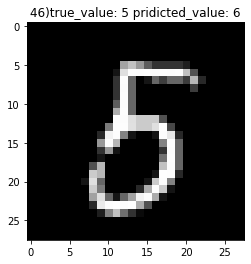

5


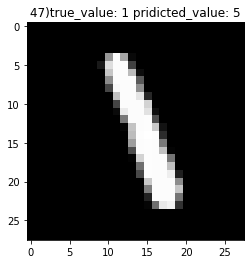

0


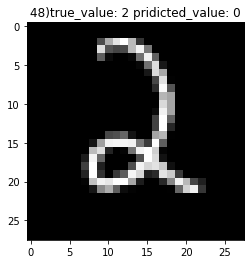

2


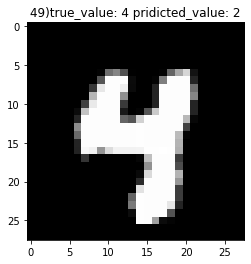

5


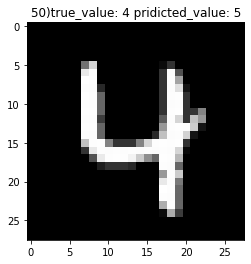

6


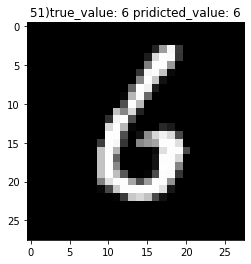

0


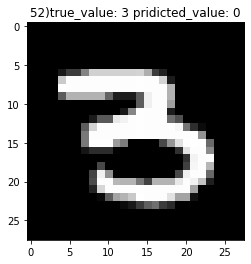

7


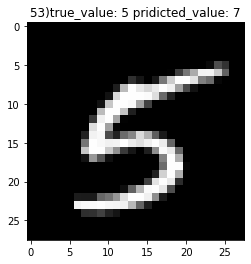

5


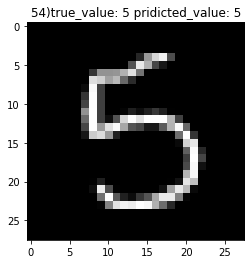

0


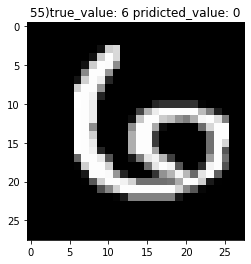

7


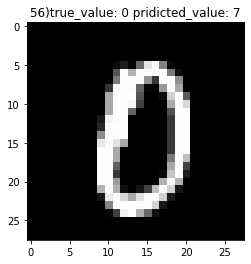

7


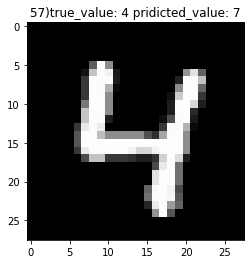

5


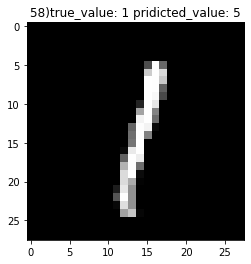

7


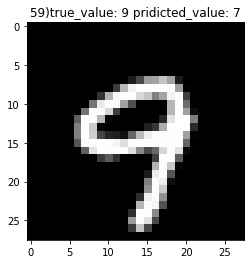

6


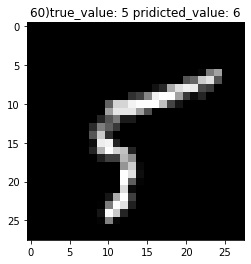

0


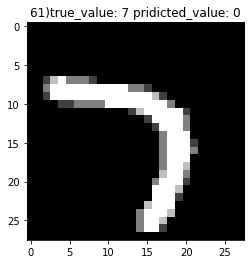

4


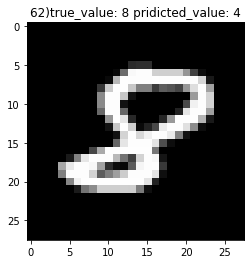

0


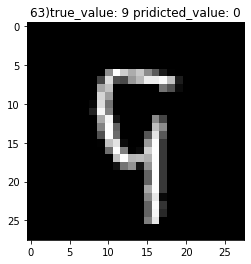

0


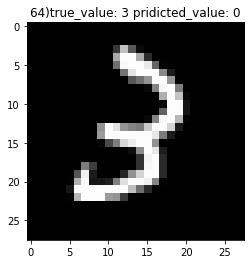

0


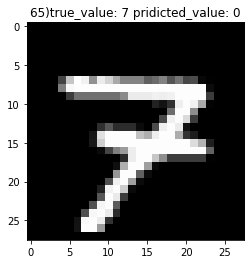

0


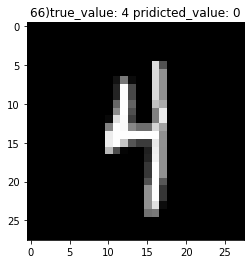

0


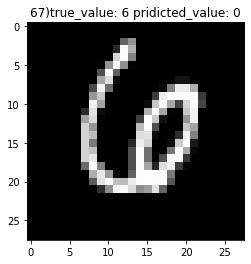

2


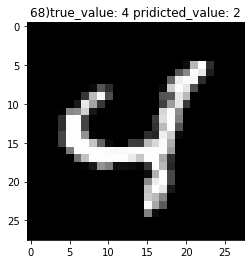

2


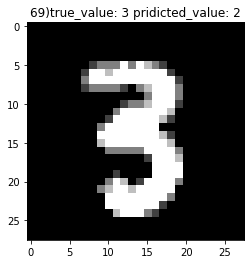

6


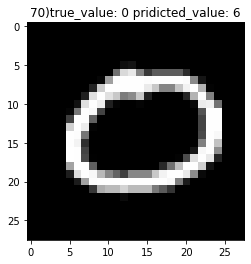

5


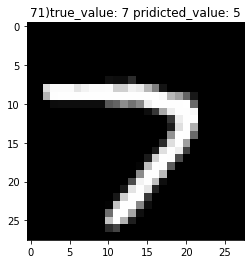

5


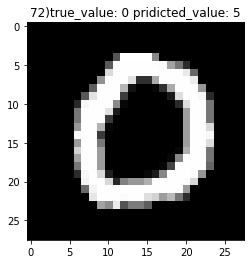

5


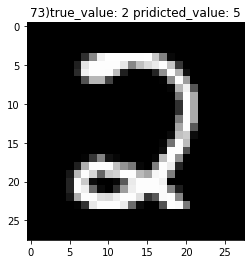

0


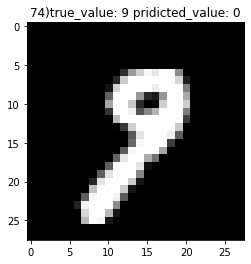

5


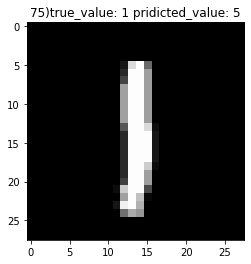

0


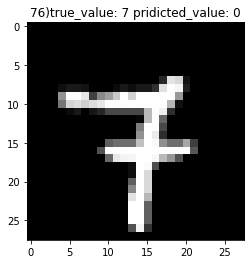

0


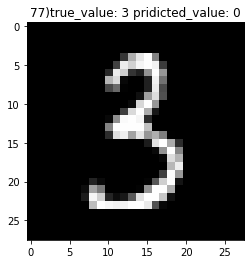

0


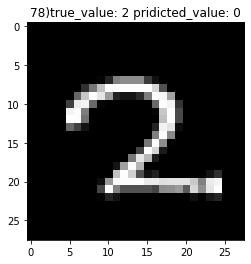

0


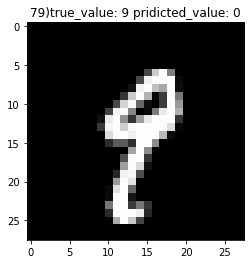

0


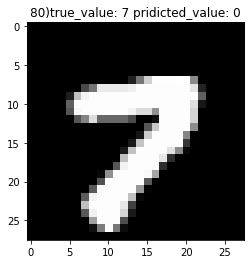

2


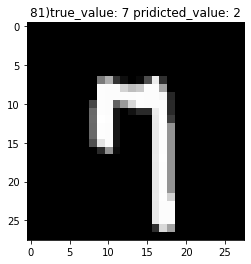

0


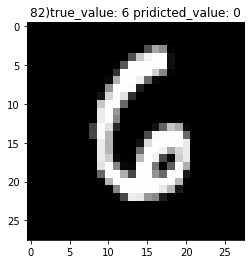

0


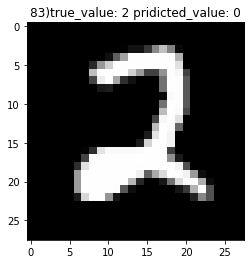

0


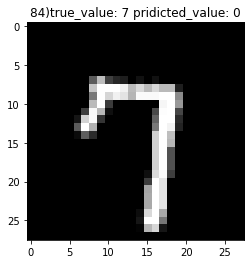

5


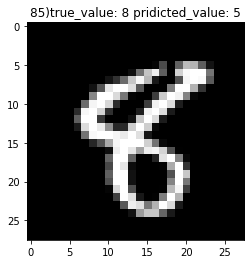

5


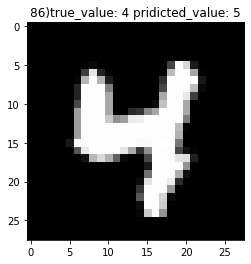

0


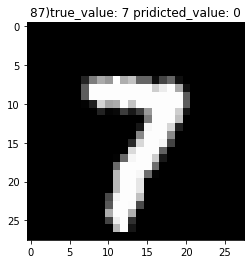

5


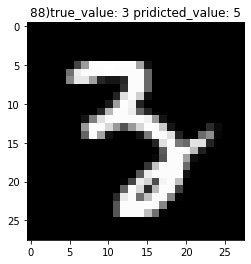

5


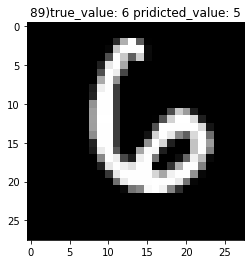

0


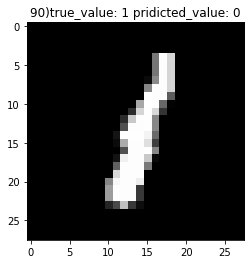

0


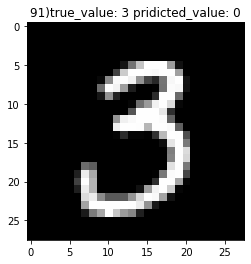

6


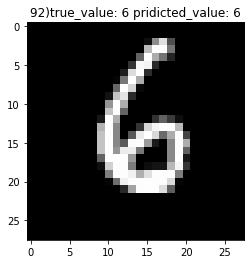

6


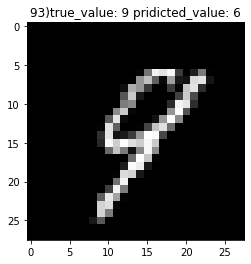

0


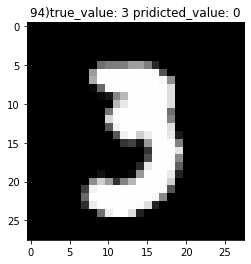

5


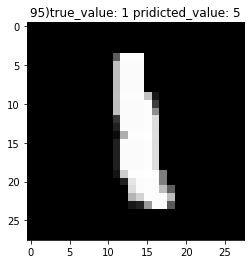

6


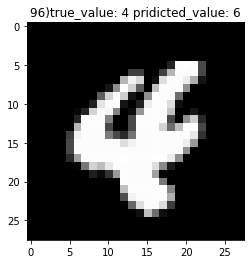

5


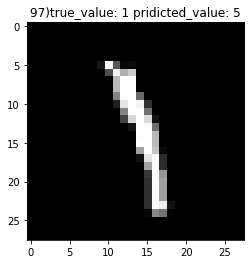

5


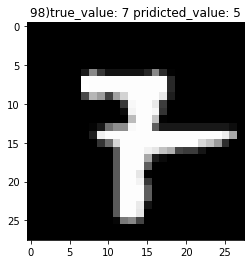

2


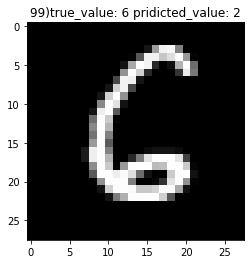

0


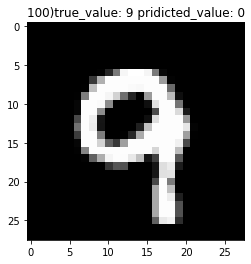

4


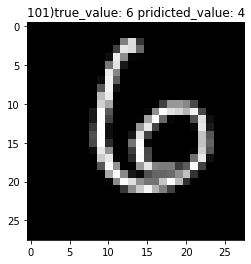

6


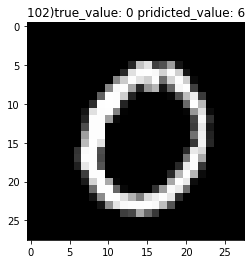

7


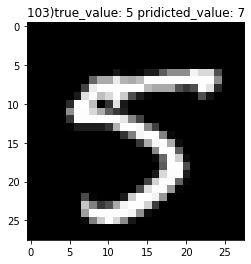

5


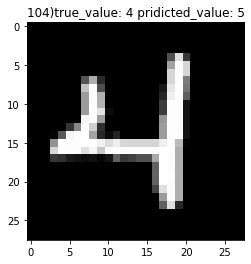

5


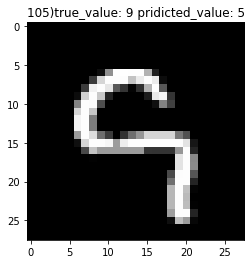

7


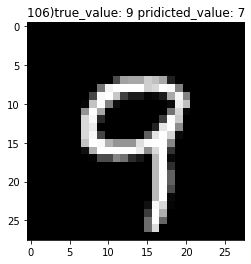

5


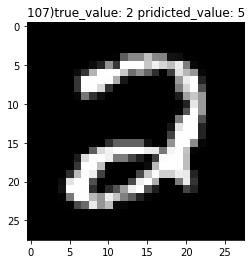

5


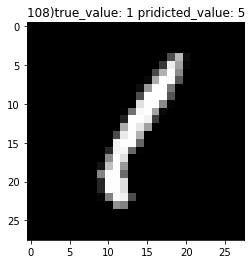

0


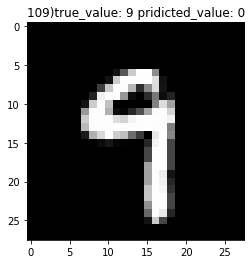

2


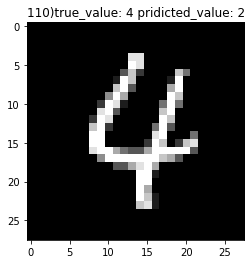

5


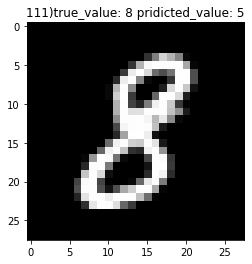

0


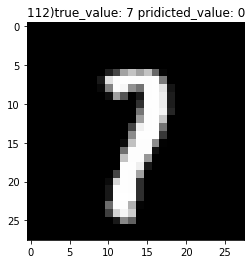

5


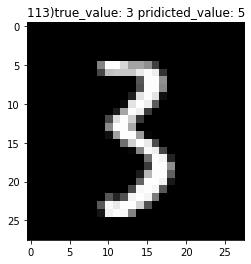

0


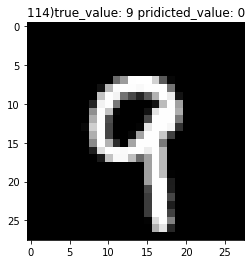

5


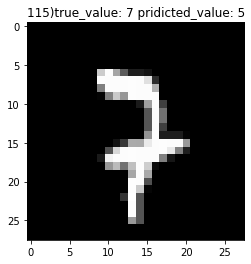

2


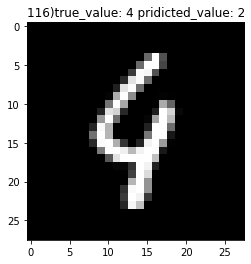

0


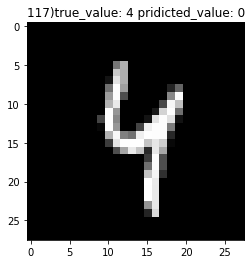

7


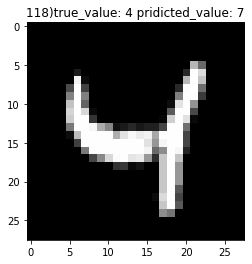

0


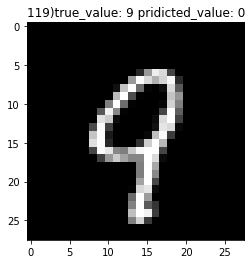

2


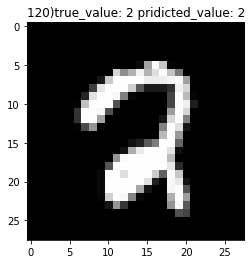

5


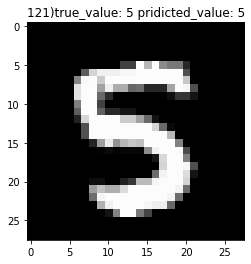

6


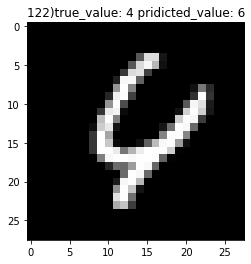

0


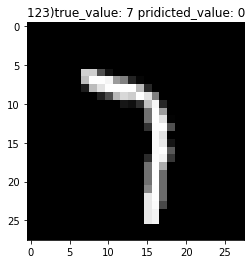

0


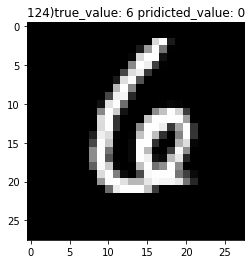

0


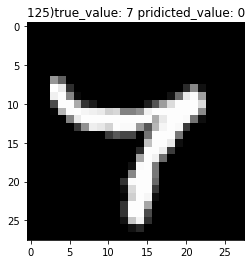

2


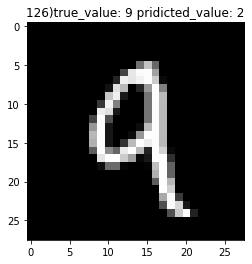

5


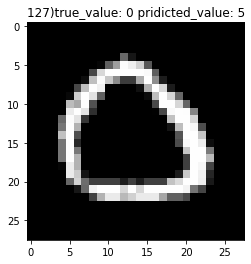

6


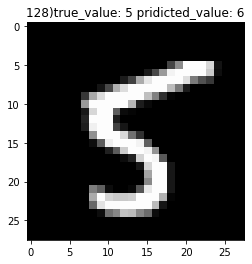

6


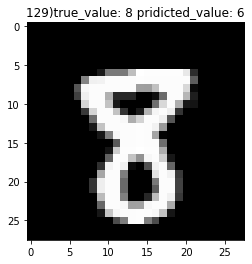

6


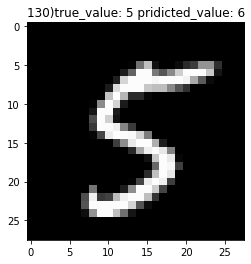

6


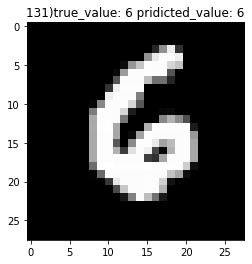

6


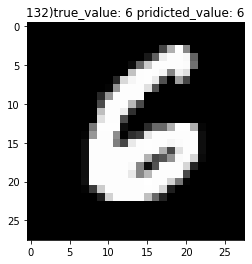

0


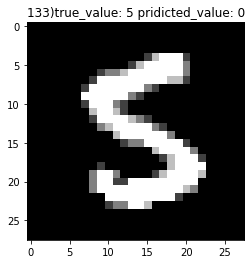

0


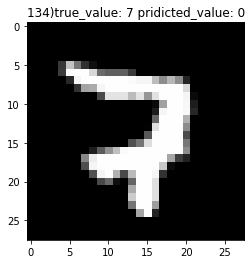

6


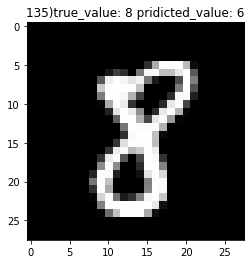

5


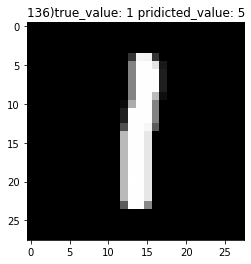

7


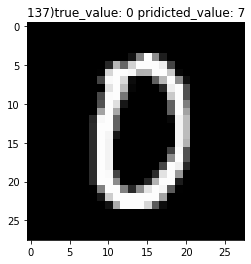

0


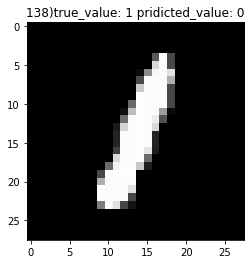

0


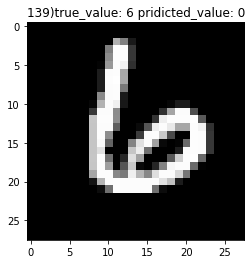

7


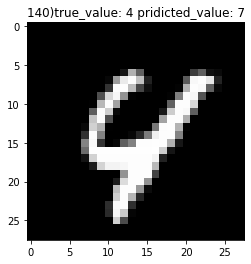

6


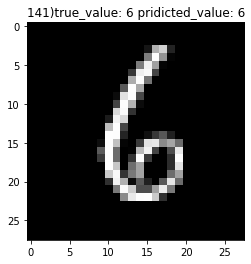

0


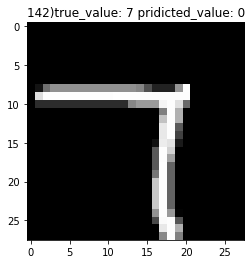

0


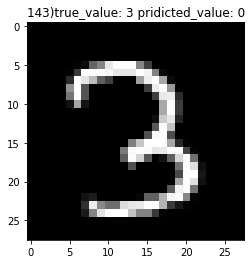

5


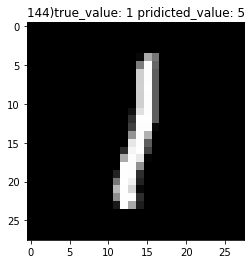

0


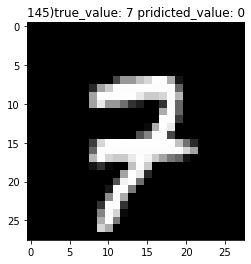

2


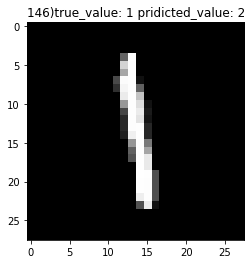

2


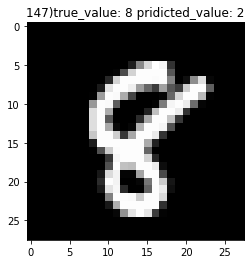

0


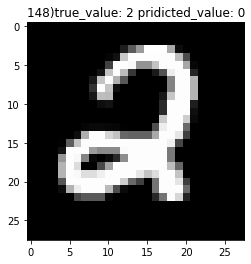

6


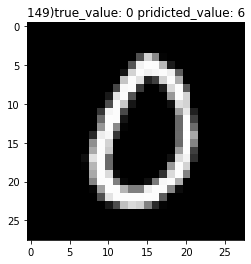

0


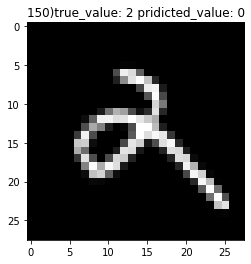

2


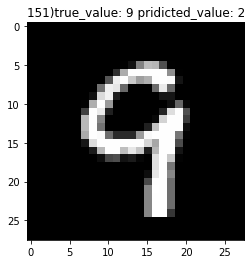

0


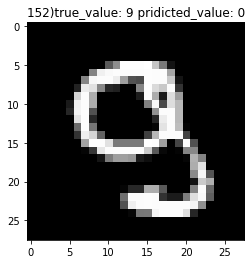

6


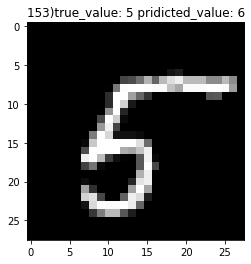

0


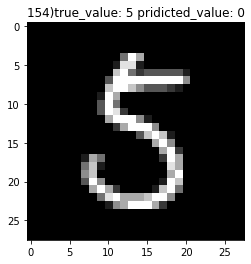

2


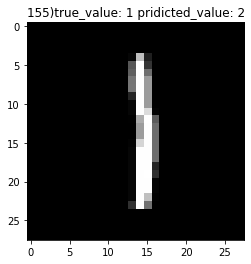

6


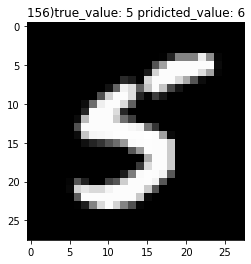

5


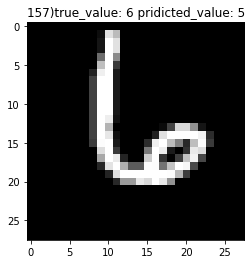

2


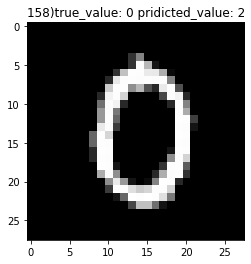

0


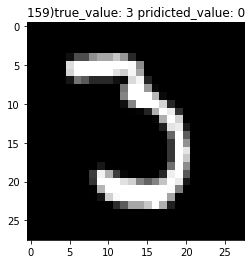

5


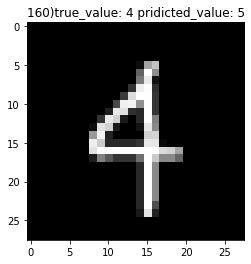

0


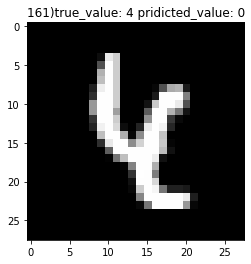

0


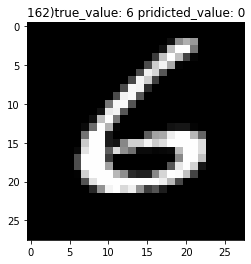

6


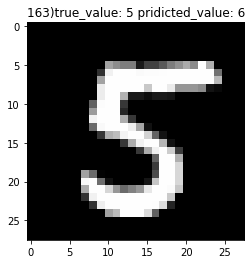

2


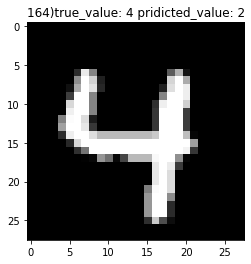

0


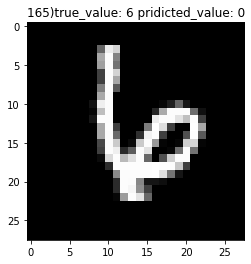

5


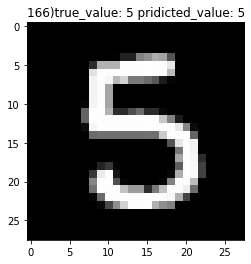

6


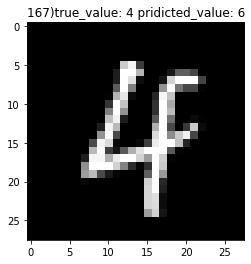

0


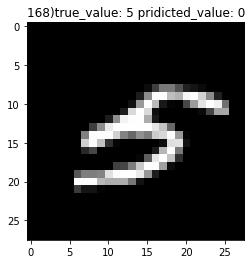

2


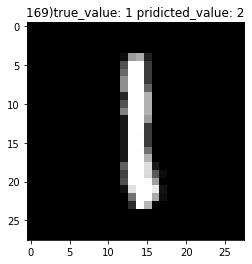

0


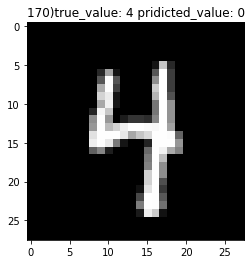

2


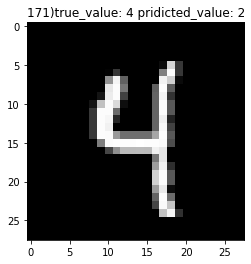

0


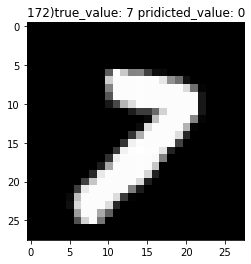

5


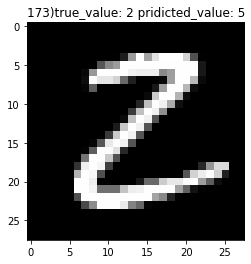

5


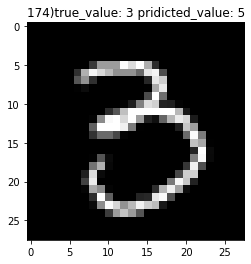

0


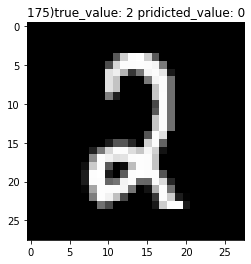

0


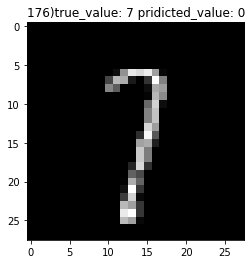

2


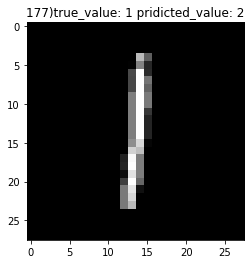

2


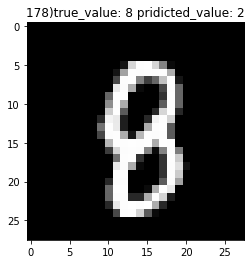

2


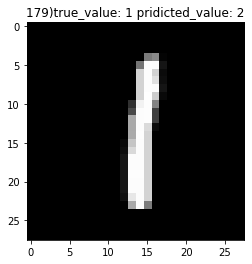

5


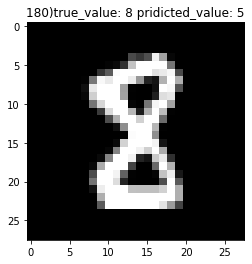

2


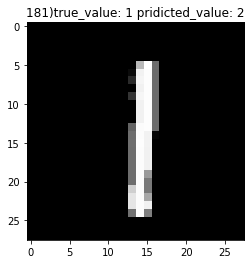

2


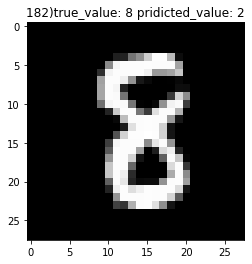

6


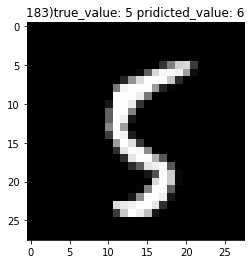

5


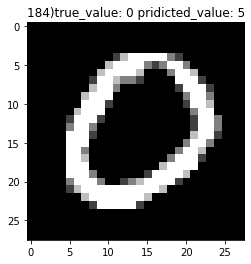

0


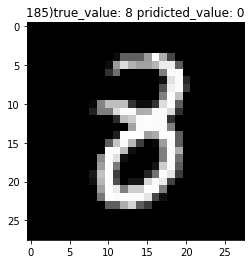

0


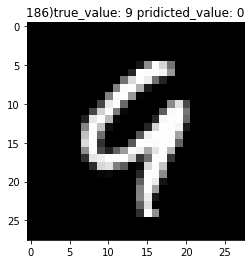

0


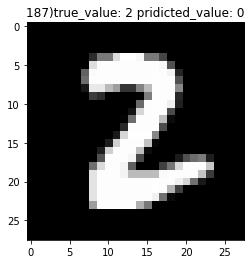

0


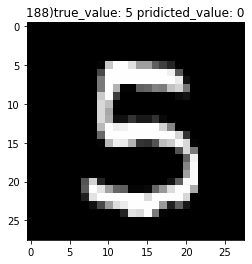

0


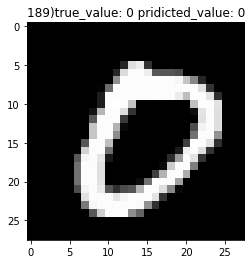

2


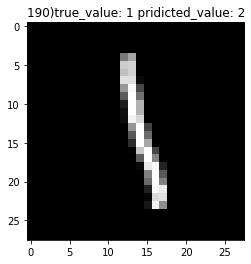

0


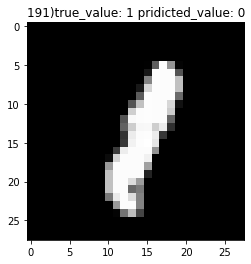

5


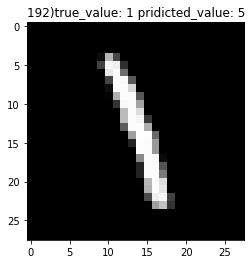

6


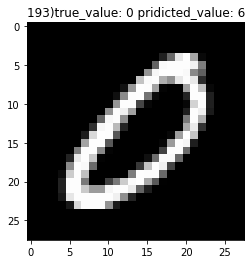

5


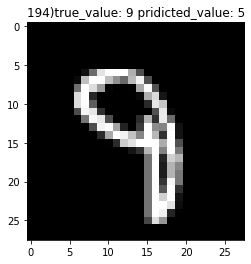

0


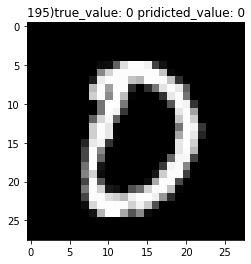

5


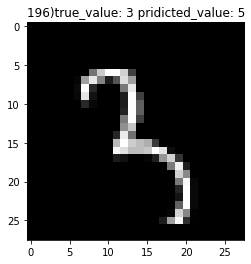

5


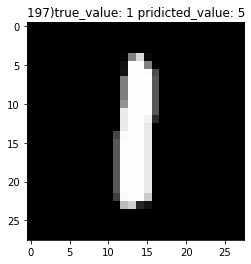

6


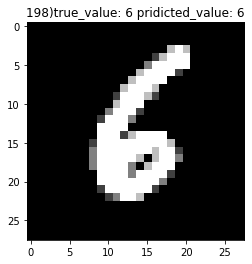

2


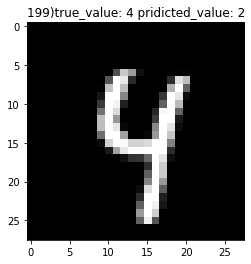

0


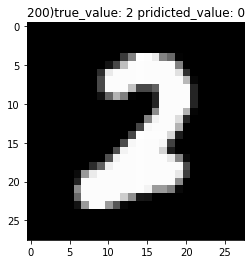

0


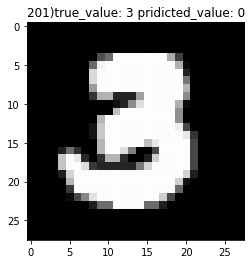

0


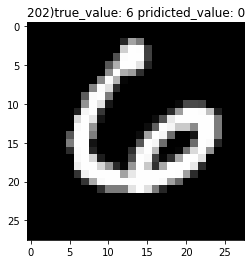

0


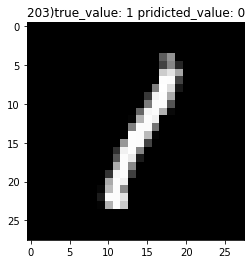

2


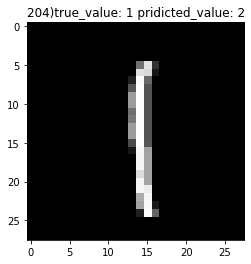

5


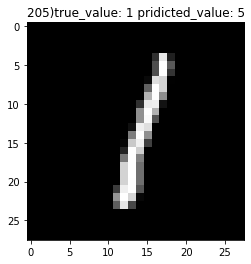

0


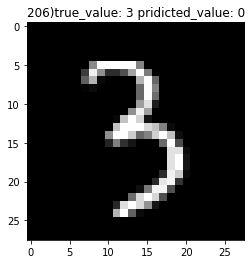

2


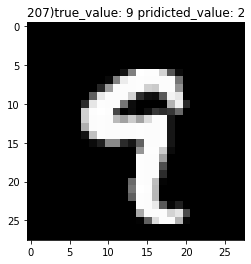

5


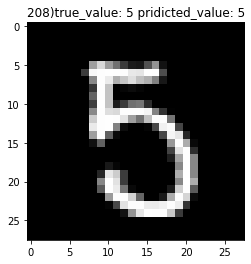

0


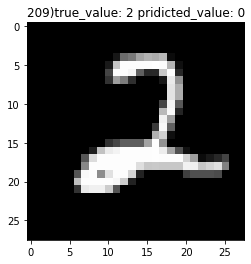

5


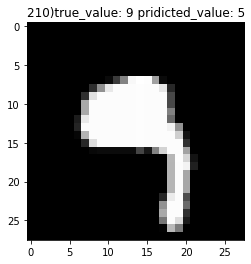

6


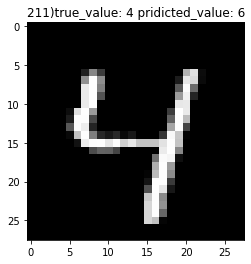

6


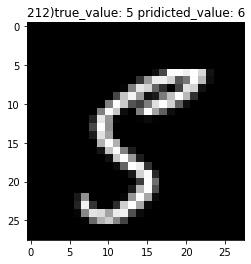

5


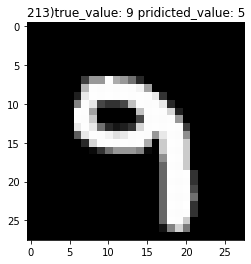

5


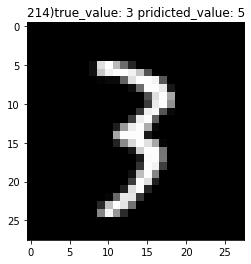

2


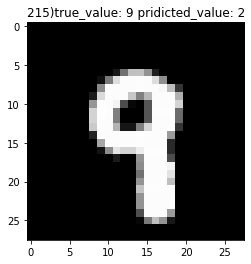

0


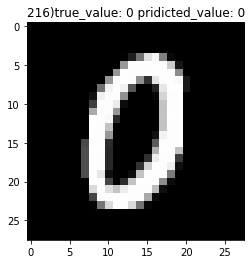

0


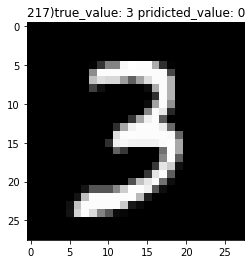

6


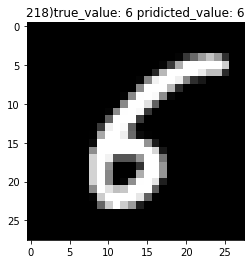

6


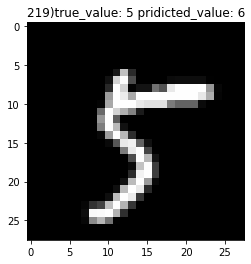

7


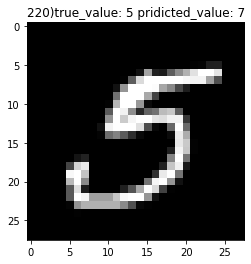

0


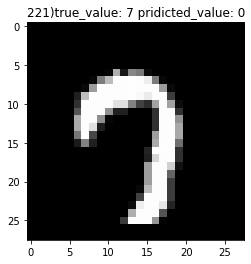

0


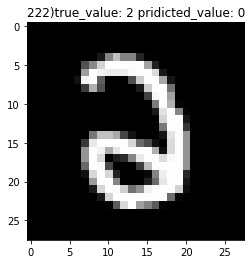

0


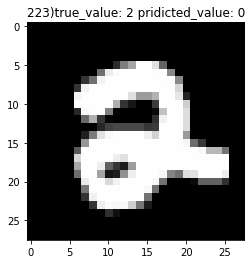

0


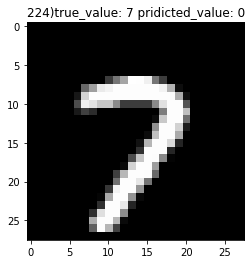

5


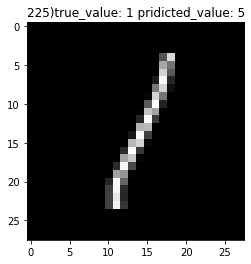

5


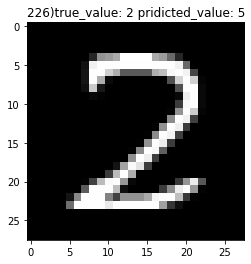

5


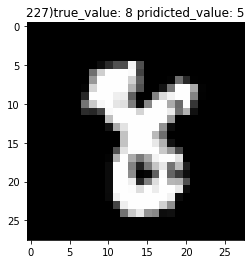

9


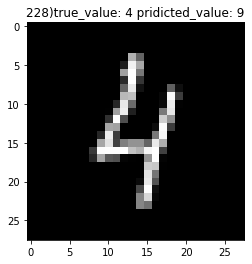

5


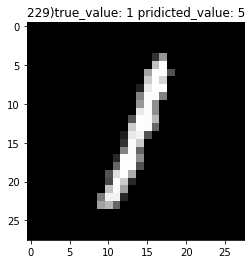

0


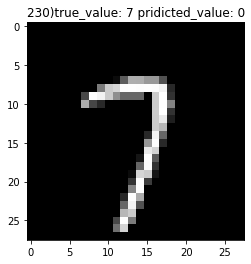

0


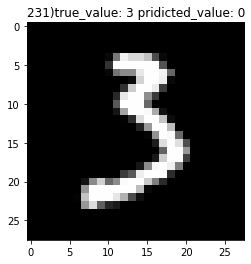

0


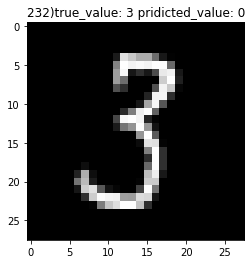

5


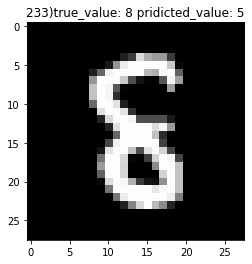

6


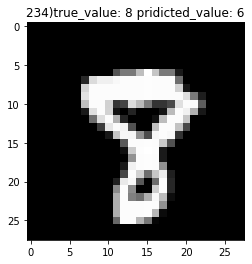

0


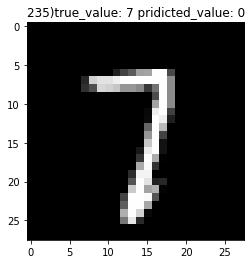

5


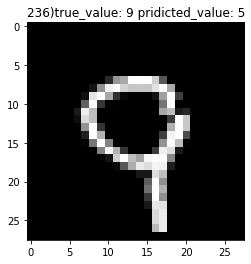

2


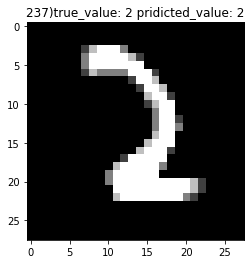

0


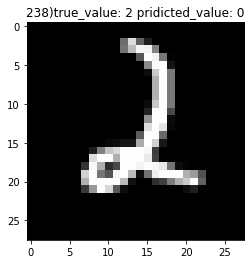

0


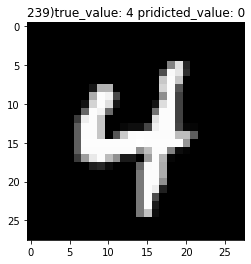

2


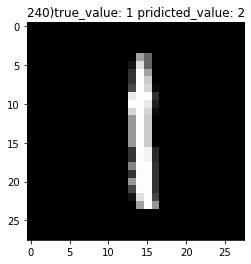

0


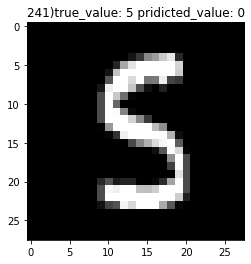

5


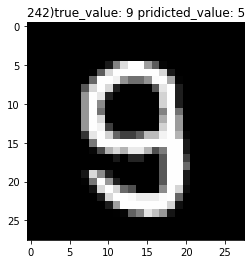

6


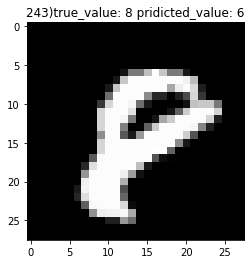

5


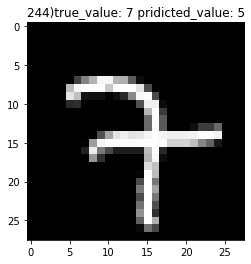

0


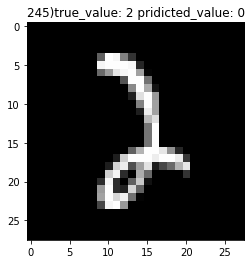

5


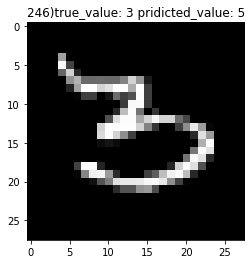

2


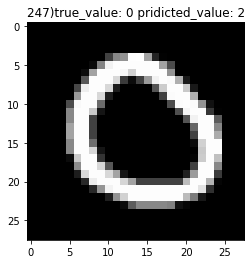

0


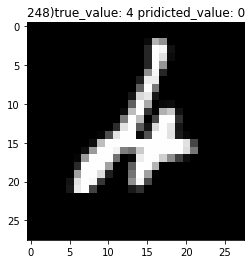

2


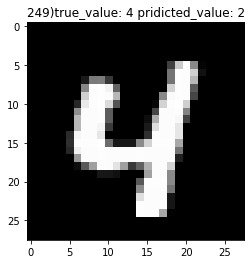

0


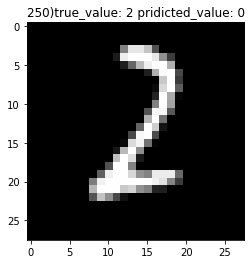

0


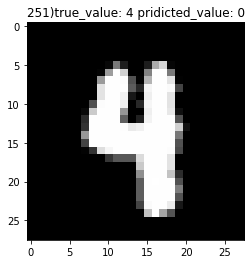

2


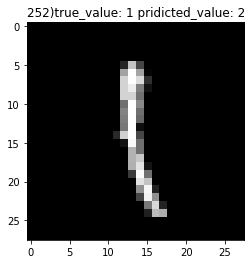

0


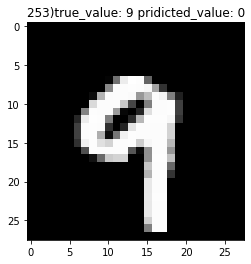

6


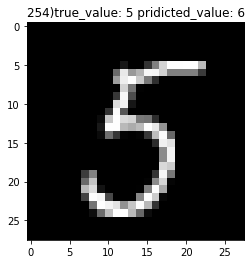

0


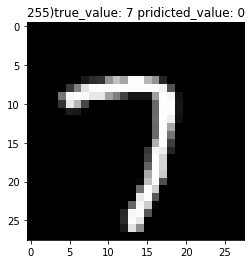

0


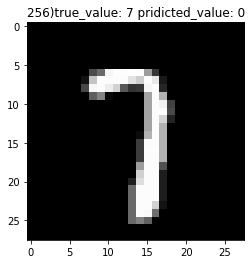

5


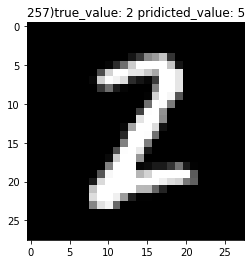

5


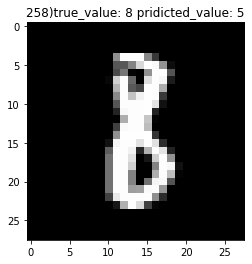

0


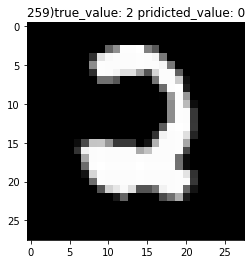

5


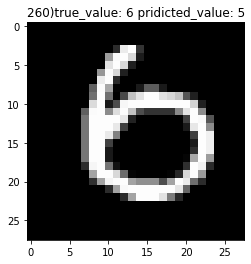

6


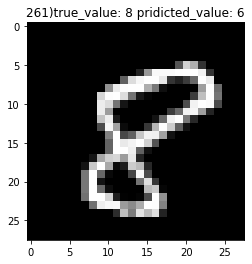

5


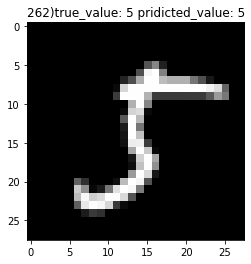

0


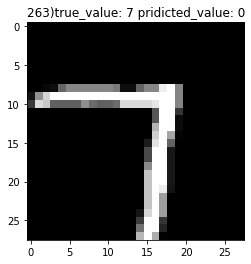

0


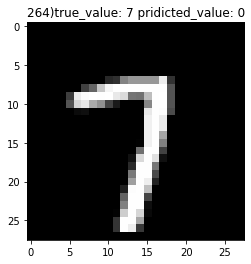

0


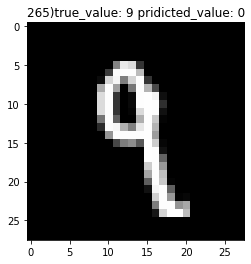

2


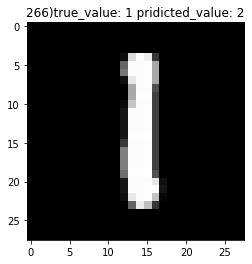

0


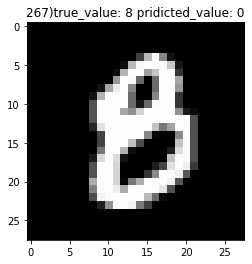

2


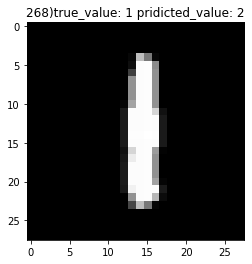

5


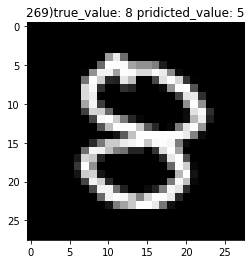

4


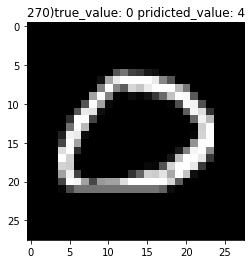

0


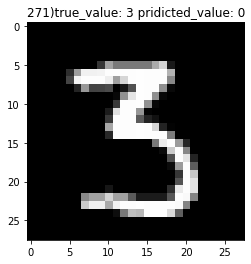

0


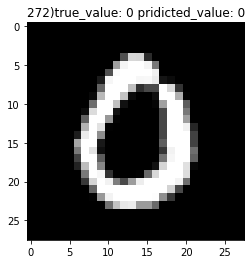

2


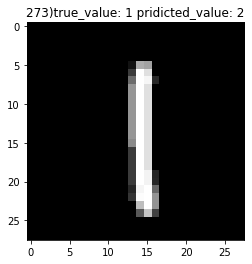

2


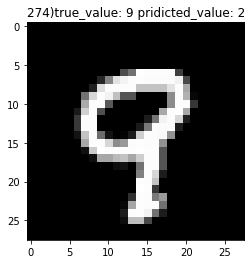

0


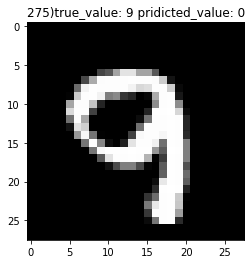

7


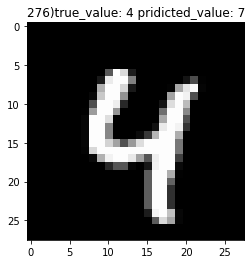

5


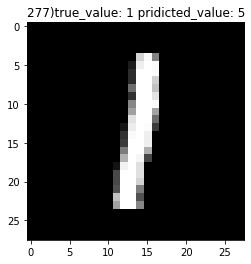

0


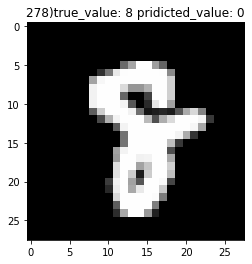

0


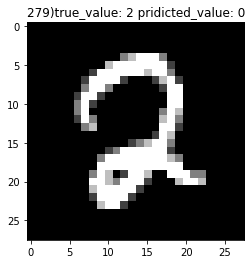

2


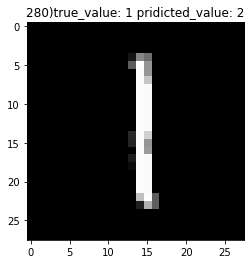

2


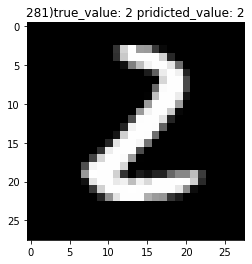

6


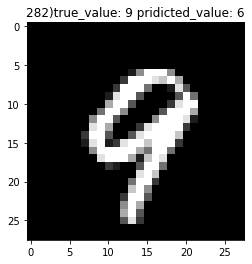

2


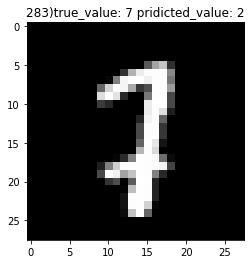

2


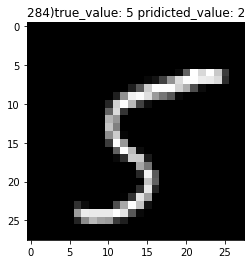

0


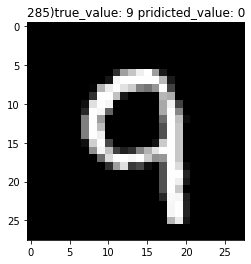

2


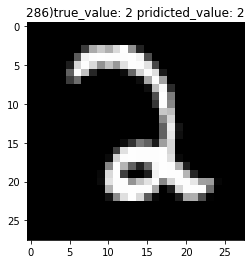

6


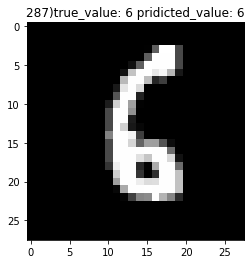

0


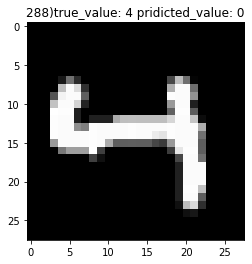

5


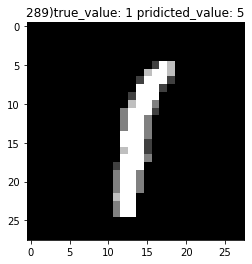

0


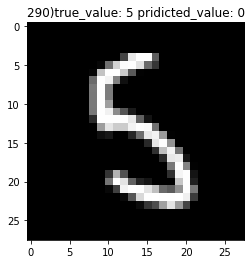

2


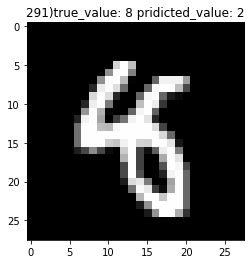

5


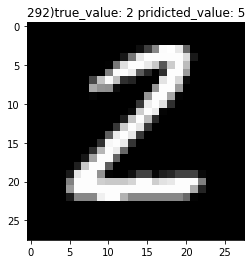

2


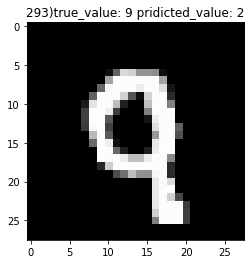

2


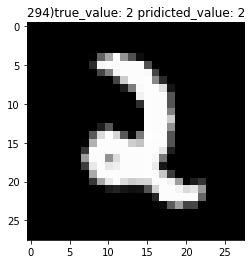

6


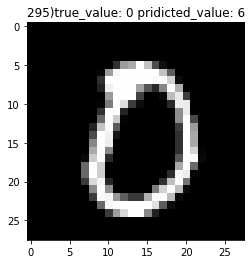

0


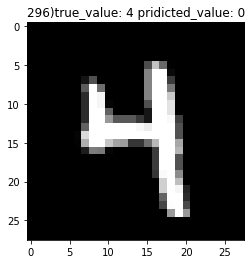

0


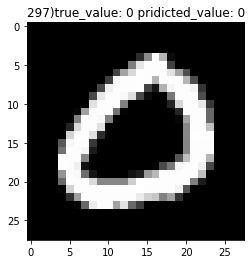

5


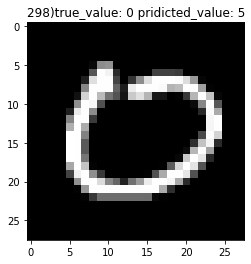

2


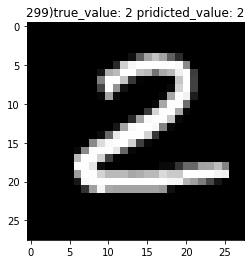

5


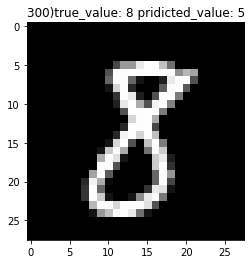

5


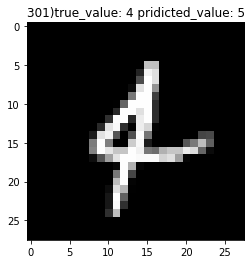

0


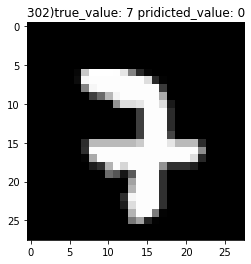

2


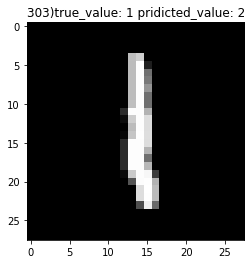

0


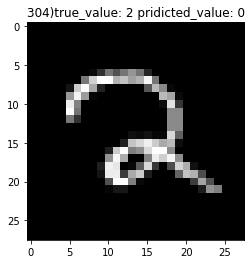

5


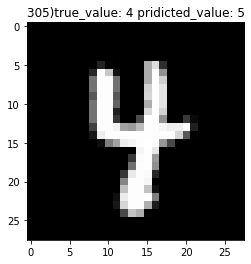

5


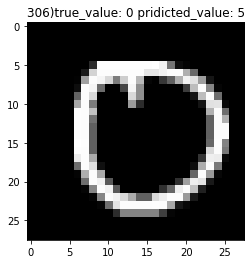

5


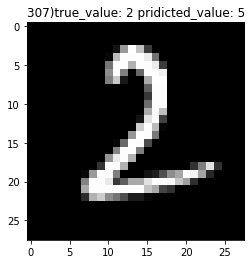

0


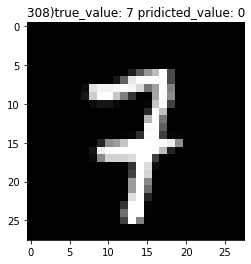

6


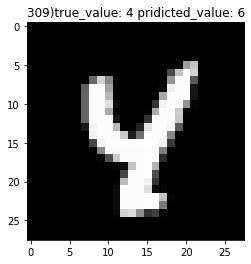

5


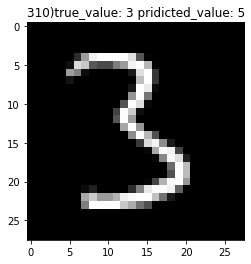

0


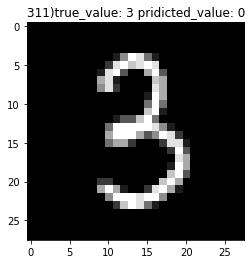

5


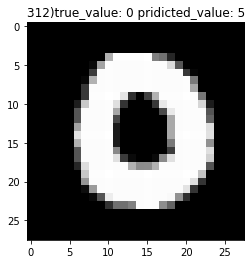

6


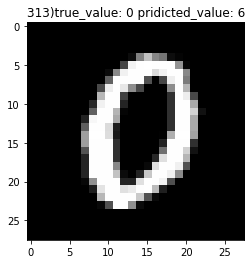

0


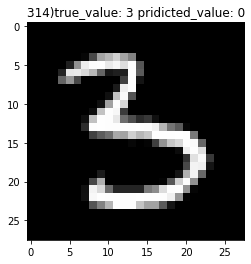

5


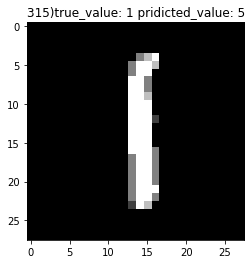

0


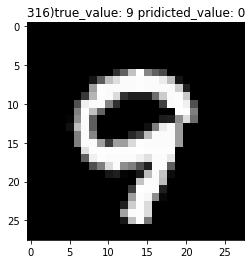

6


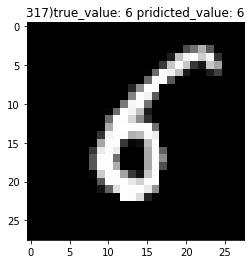

5


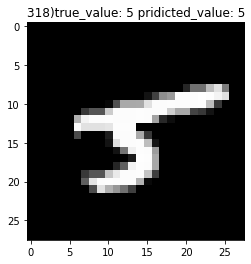

0


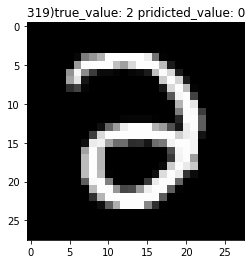

5


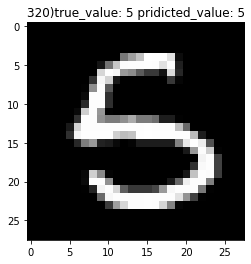

2


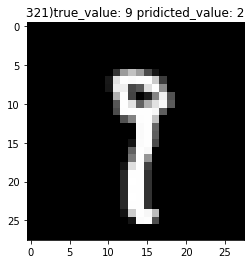

0


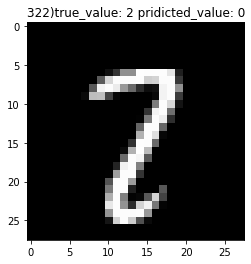

2


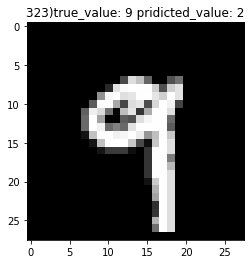

5


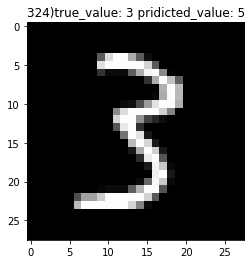

0


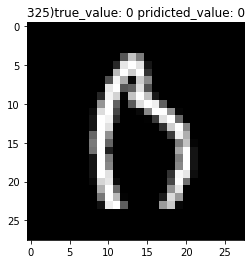

6


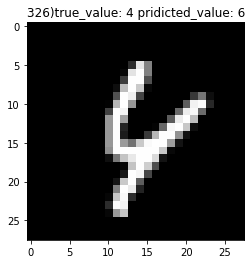

2


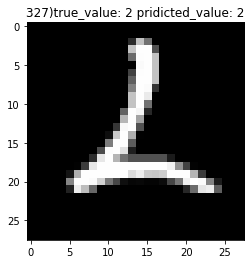

6


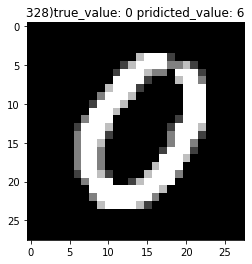

0


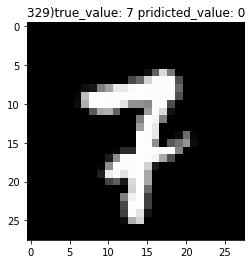

2


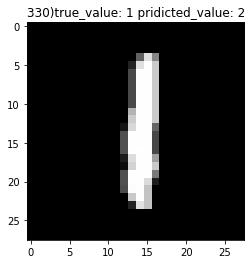

2


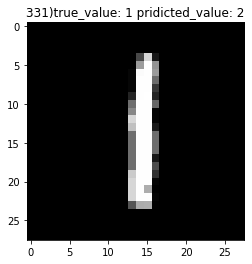

2


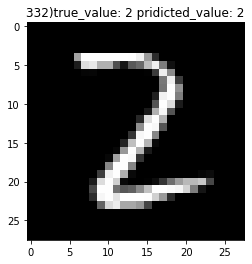

2


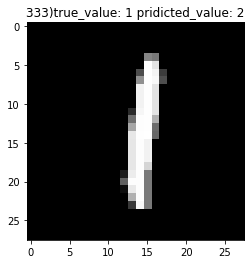

6


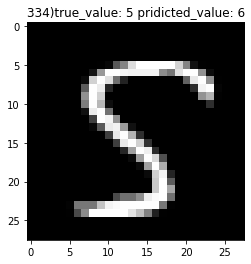

0


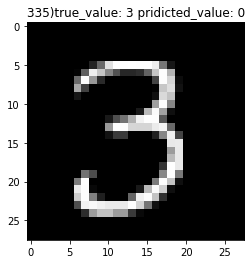

5


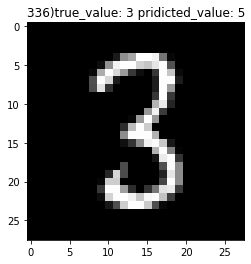

2


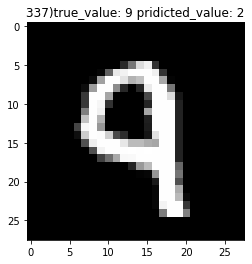

0


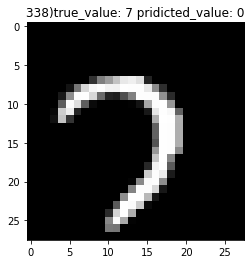

0


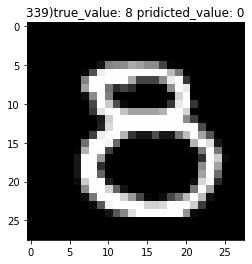

6


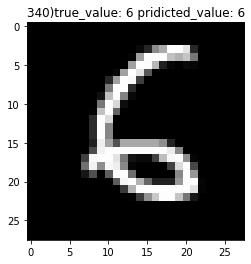

0


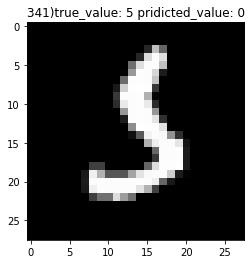

0


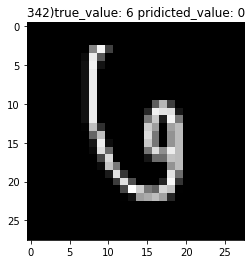

5


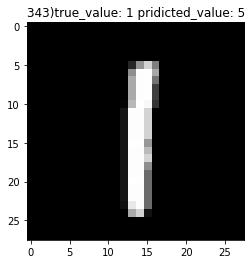

5


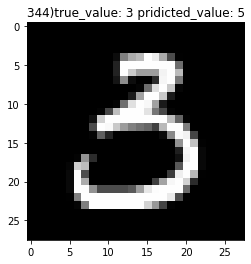

5


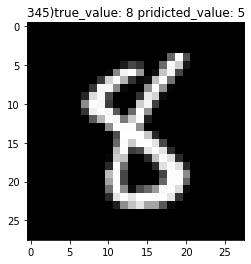

2


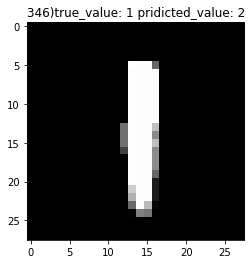

6


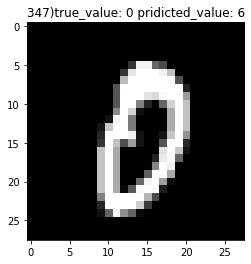

6


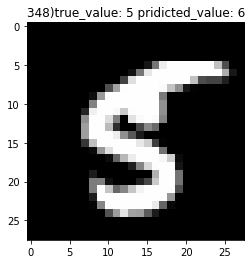

5


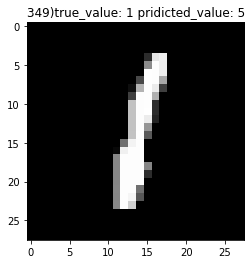

0


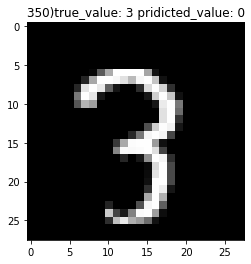

2


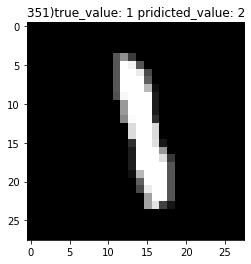

5


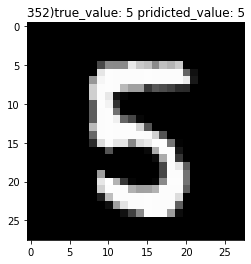

5


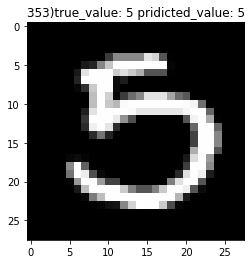

0


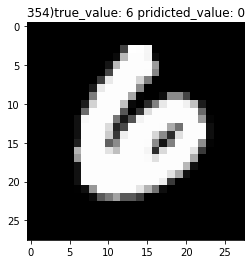

5


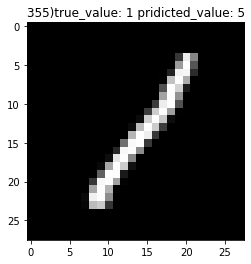

6


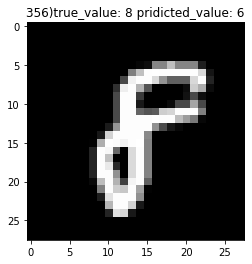

6


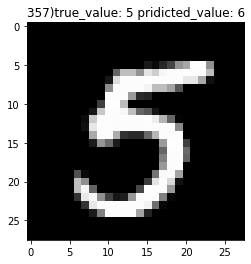

2


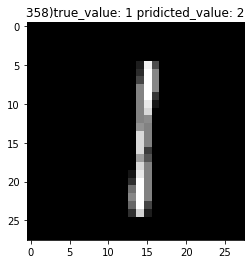

2


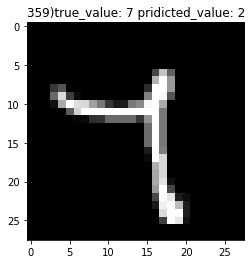

2


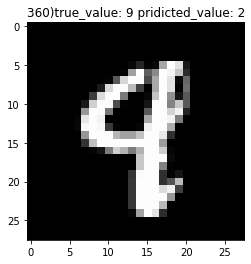

0


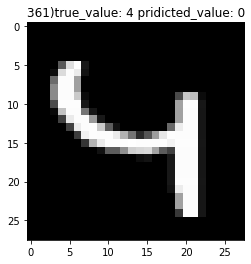

0


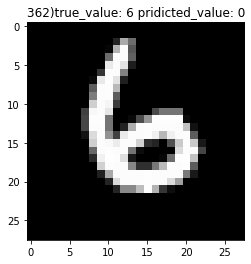

2


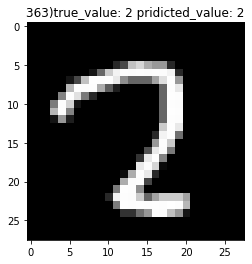

2


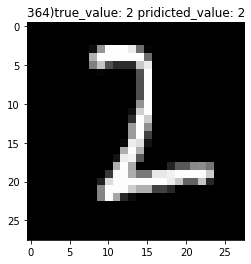

6


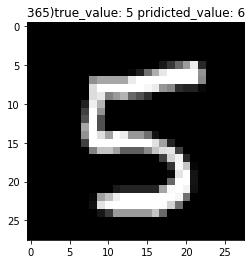

6


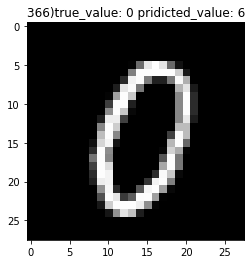

0


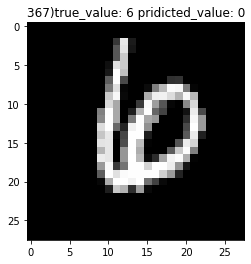

0


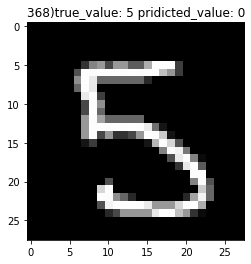

3


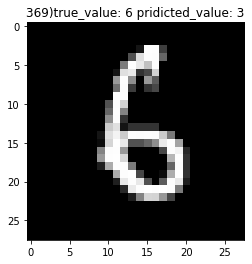

0


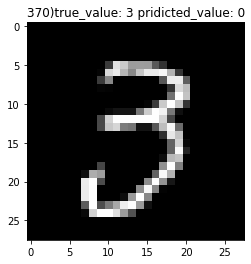

2


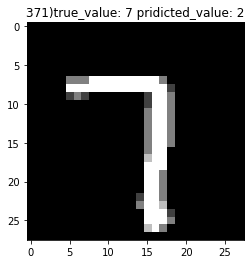

5


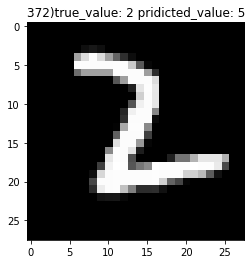

0


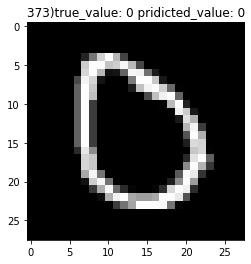

2


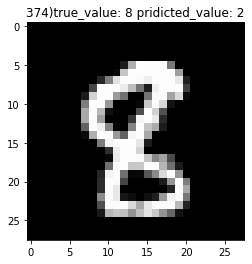

4


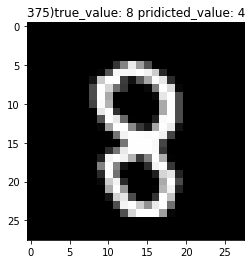

6


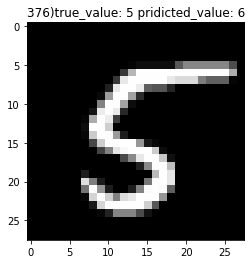

6


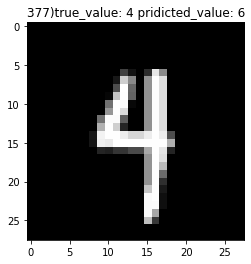

2


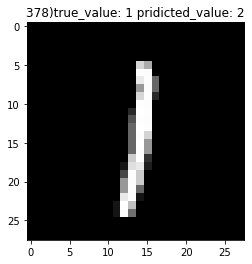

5


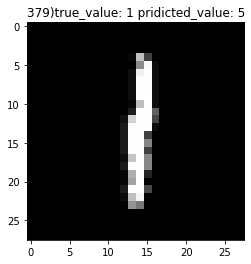

7


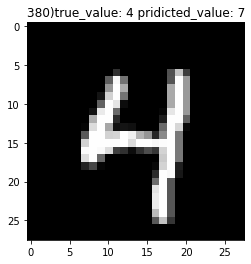

5


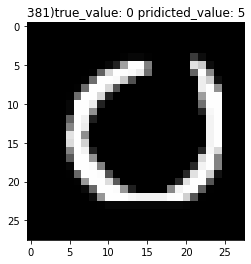

0


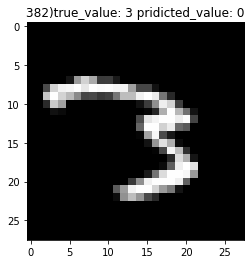

5


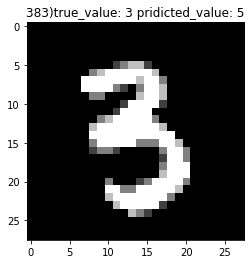

0


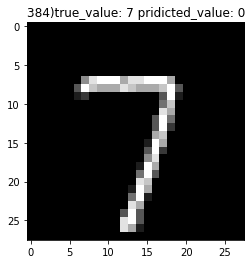

0


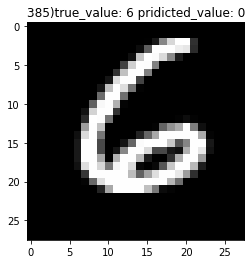

5


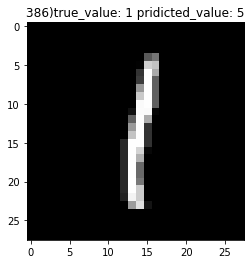

6


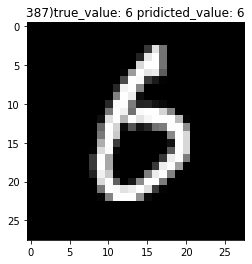

2


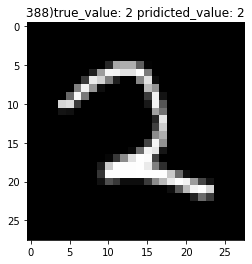

5


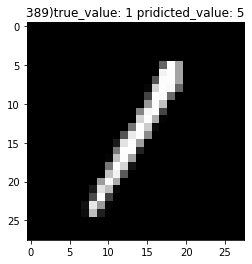

0


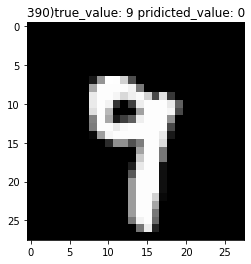

0


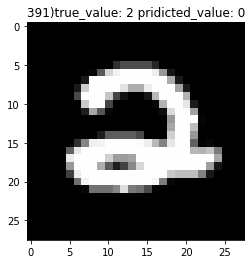

6


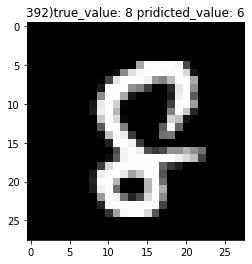

6


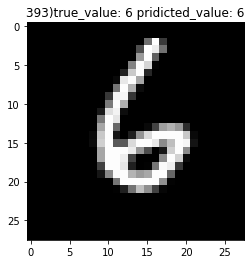

2


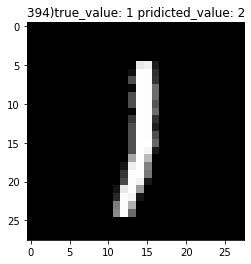

0


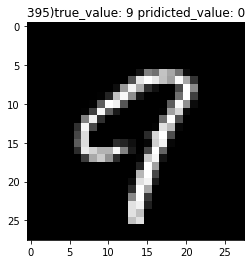

5


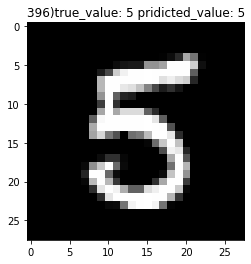

0


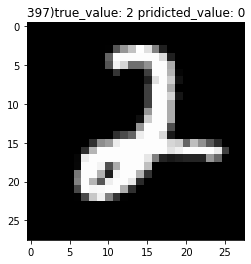

0


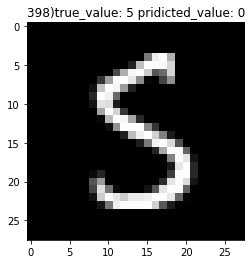

2


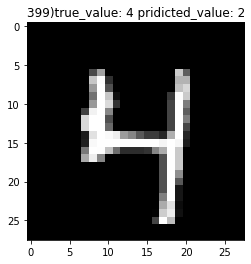

7


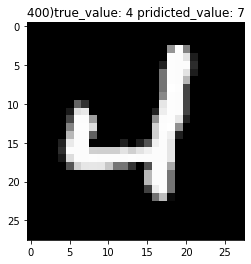

0


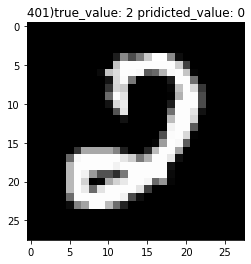

2


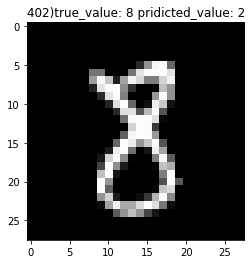

0


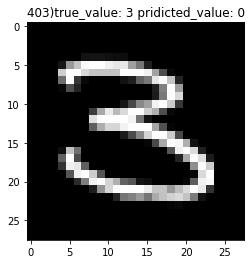

6


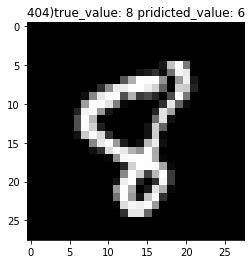

0


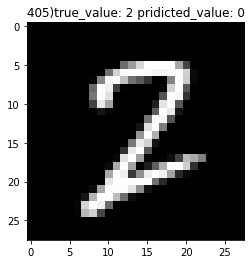

0


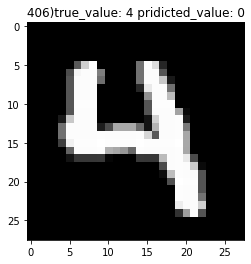

0


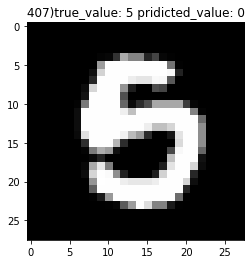

0


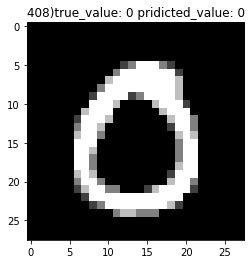

0


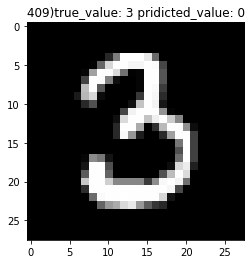

5


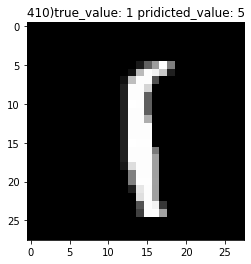

0


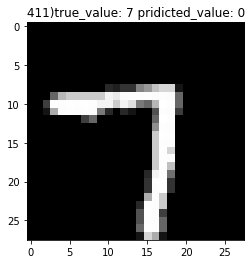

0


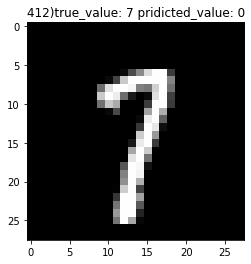

0


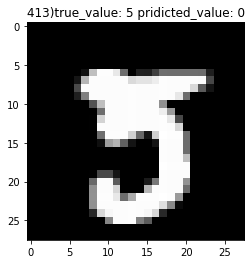

0


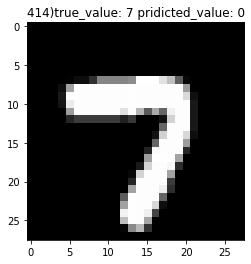

2


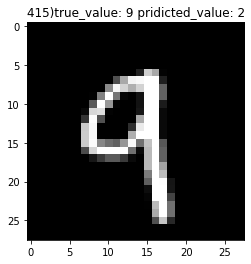

2


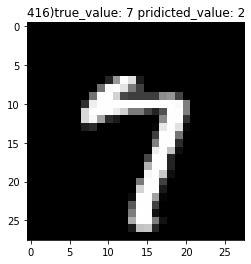

5


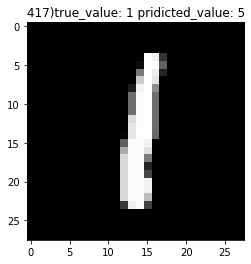

0


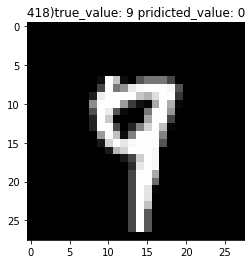

0


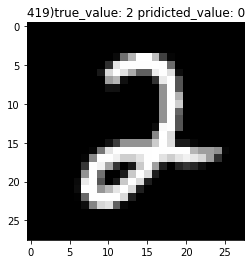

2


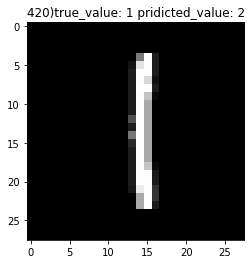

6


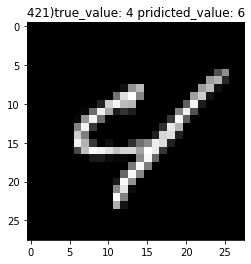

5


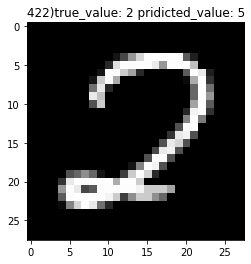

0


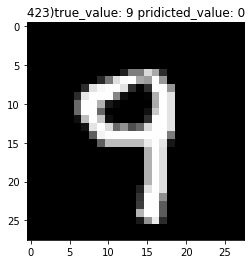

2


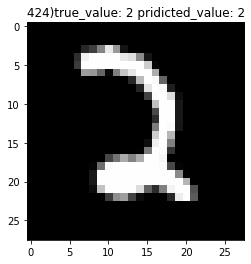

0


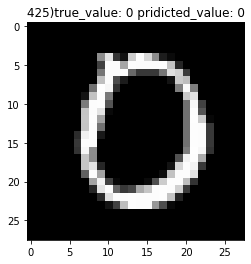

0


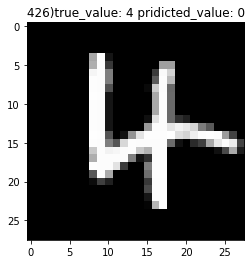

0


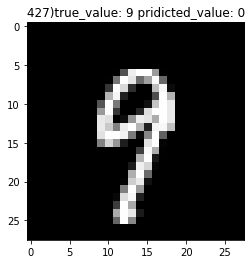

2


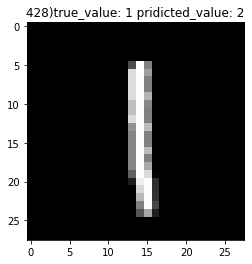

2


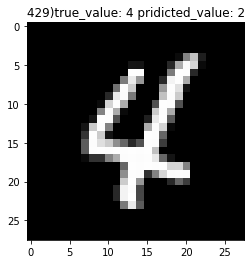

5


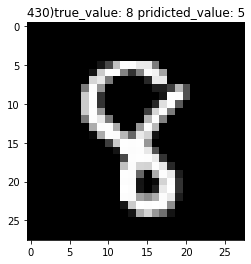

5


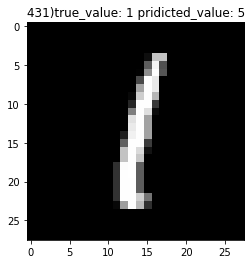

0


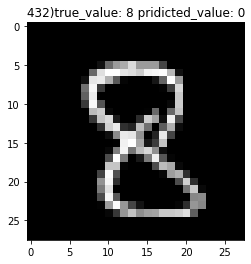

0


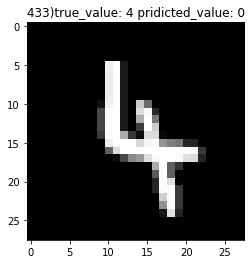

6


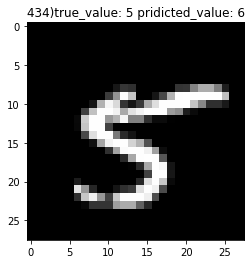

6


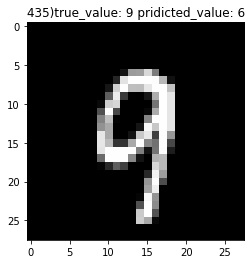

2


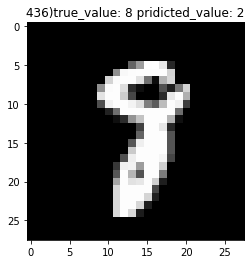

6


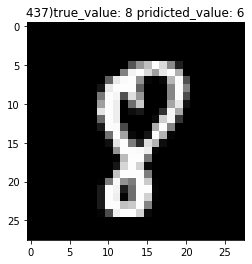

0


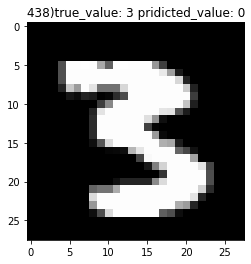

0


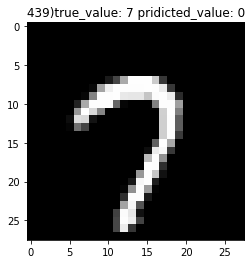

6


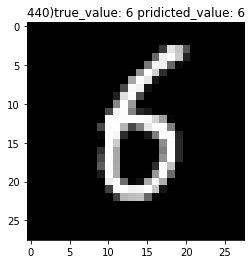

0


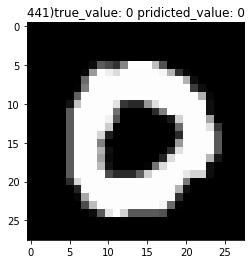

6


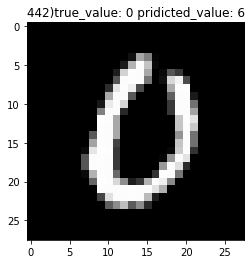

5


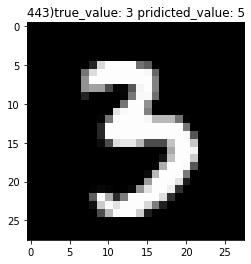

6


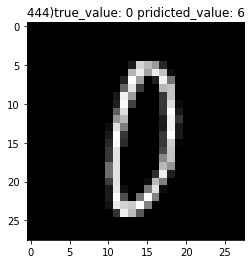

6


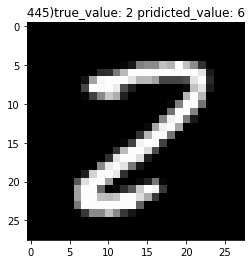

7


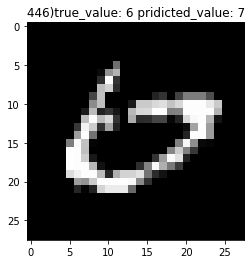

0


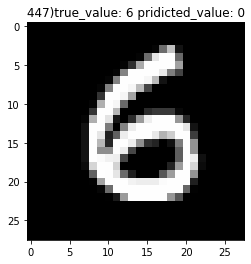

0


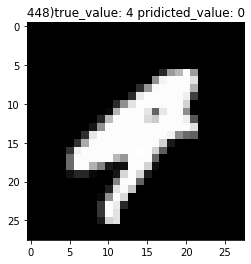

6


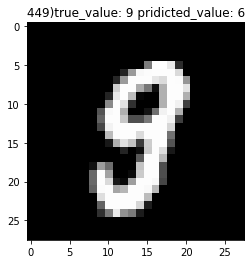

0


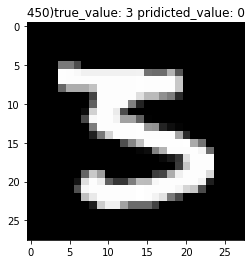

0


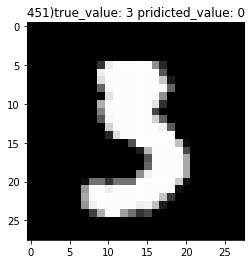

0


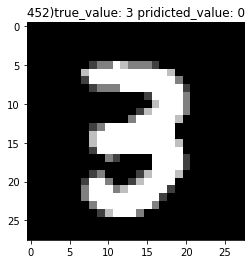

5


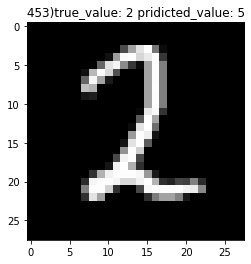

5


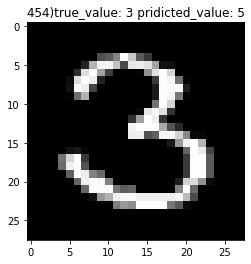

7


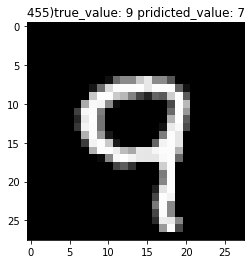

5


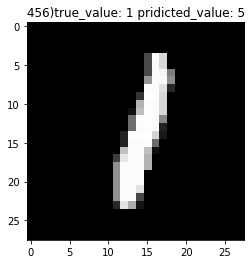

0


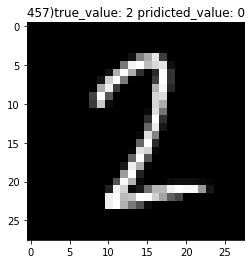

6


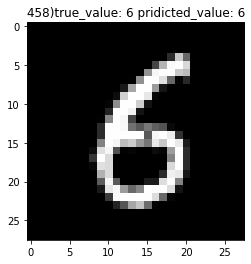

6


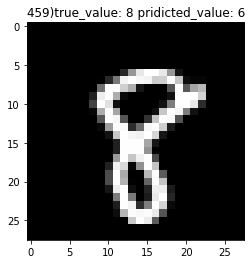

4


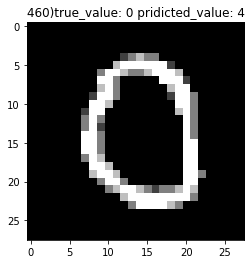

0


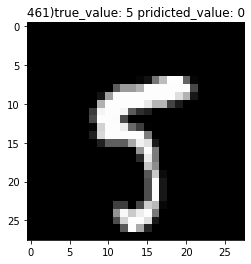

5


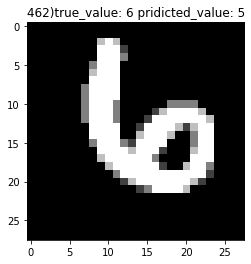

5


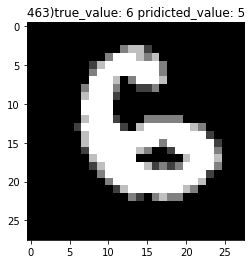

0


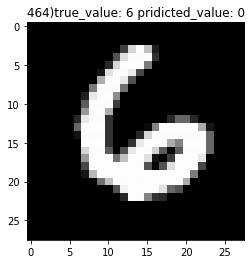

0


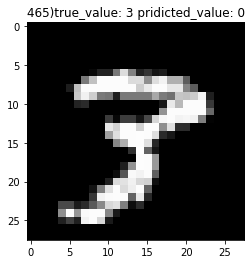

6


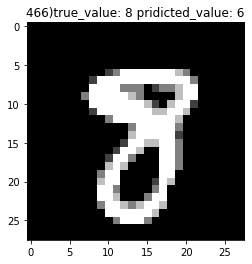

6


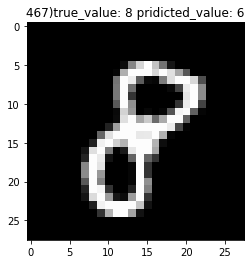

0


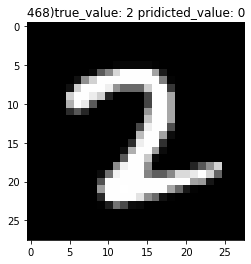

4


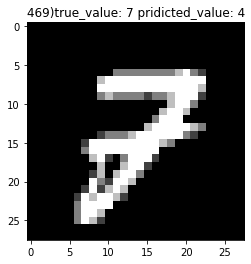

5


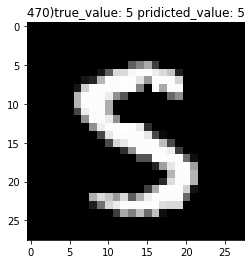

5


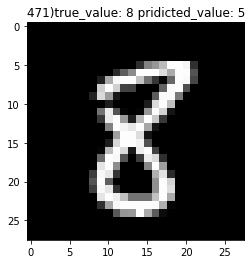

0


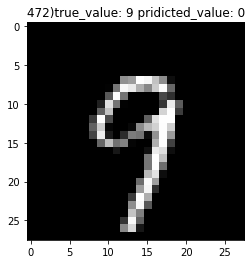

0


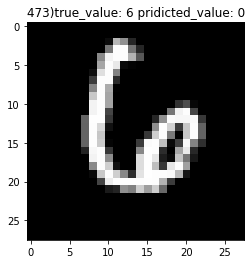

2


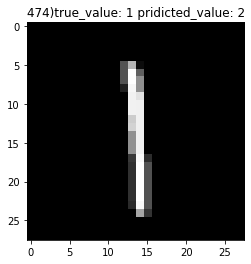

6


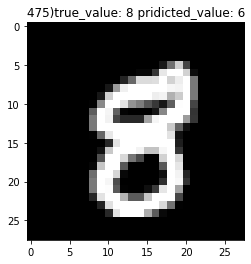

0


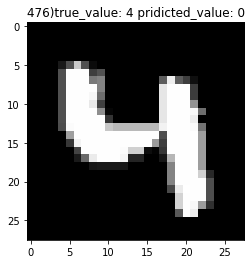

5


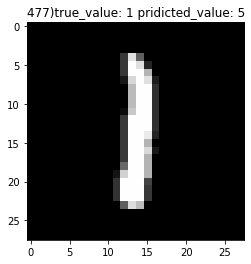

0


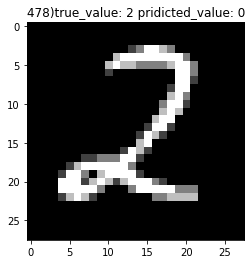

7


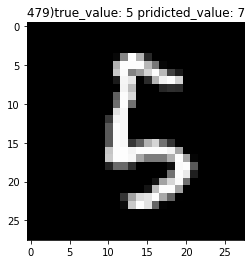

0


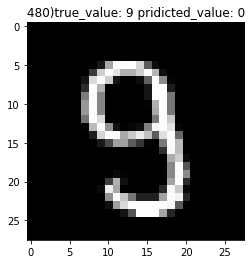

5


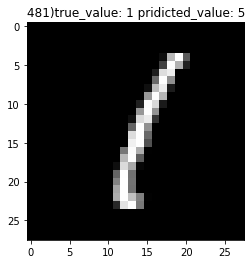

0


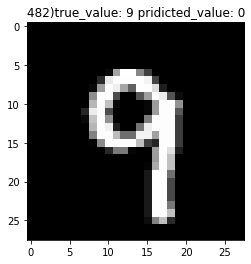

5


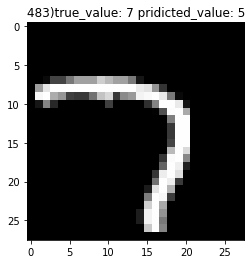

7


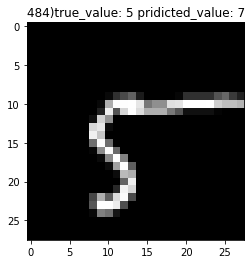

0


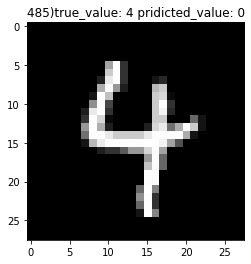

7


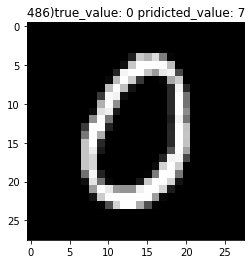

6


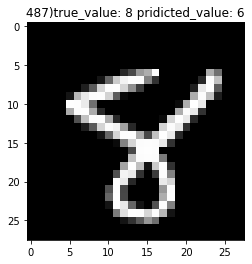

2


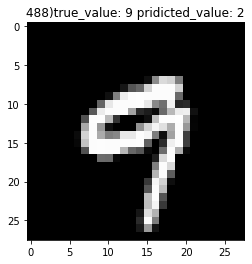

0


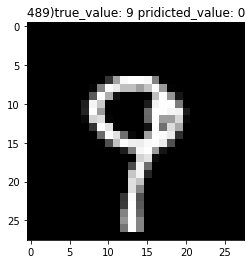

5


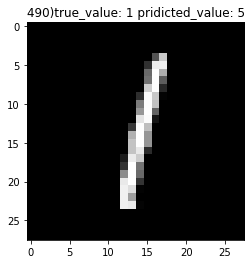

7


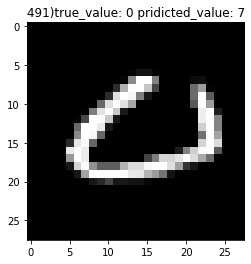

6


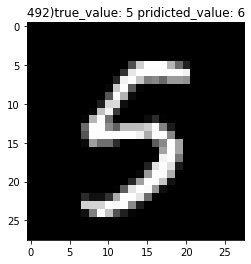

2


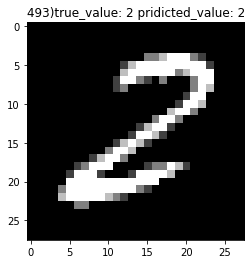

5


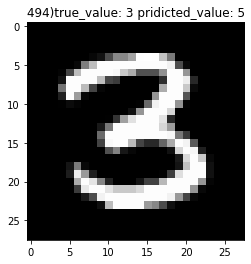

0


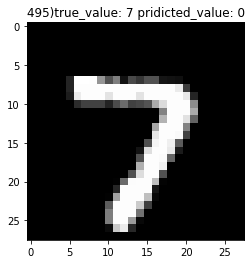

0


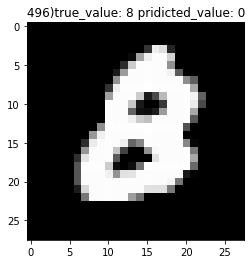

2


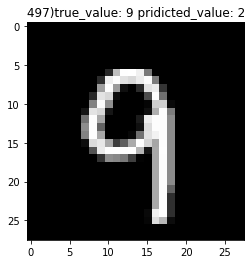

0


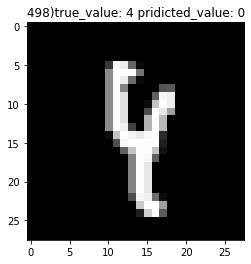

6


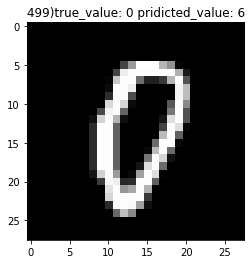

6


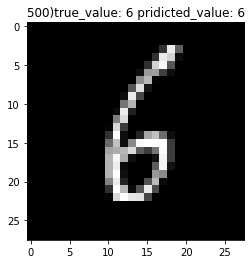

0


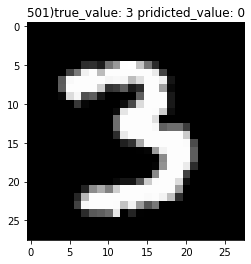

4


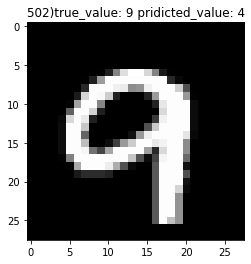

5


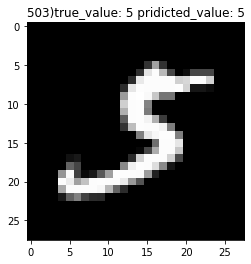

0


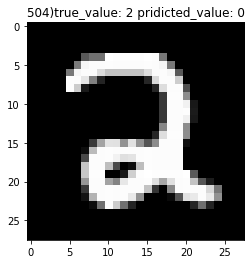

5


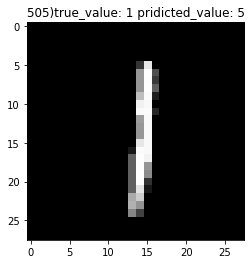

0


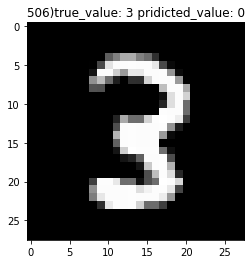

4


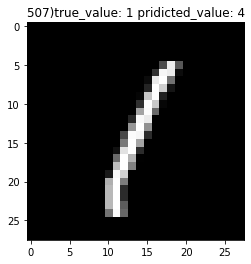

2


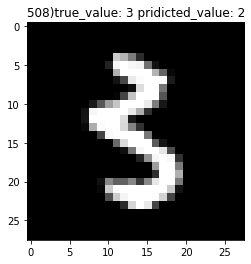

6


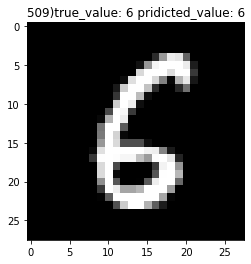

6


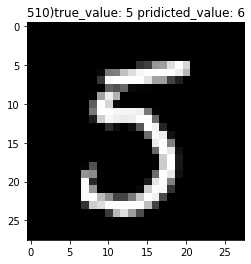

4


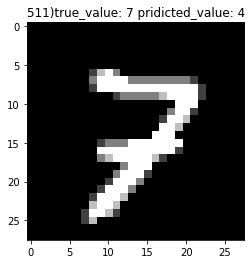

0


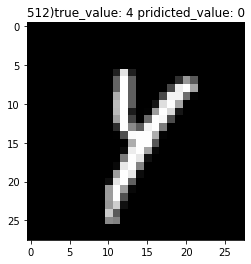

2


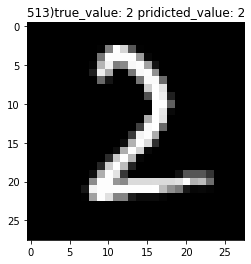

0


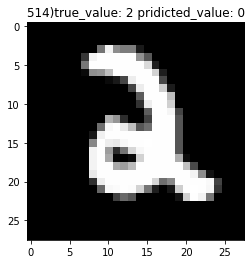

0


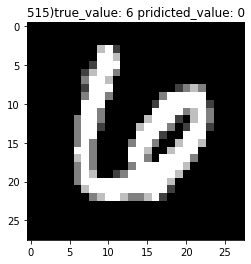

0


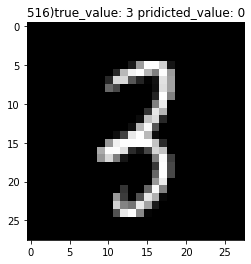

6


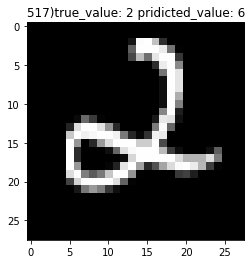

7


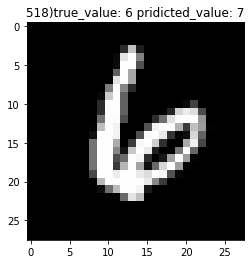

5


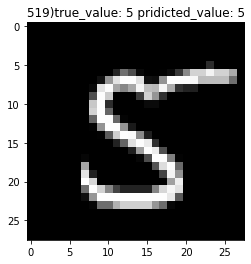

2


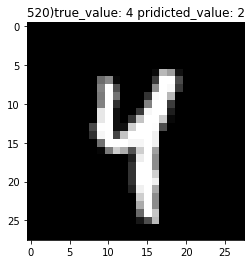

1


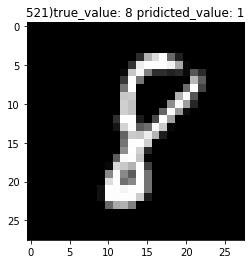

6


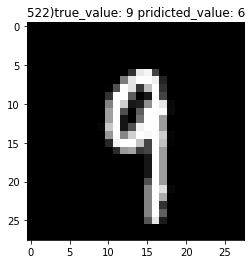

0


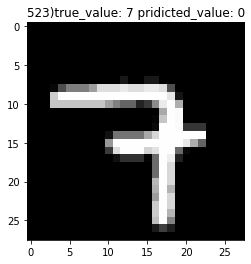

5


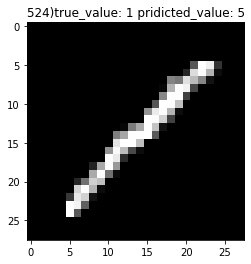

0


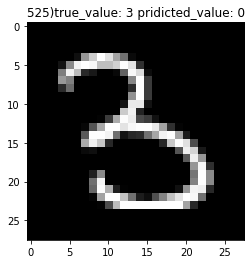

0


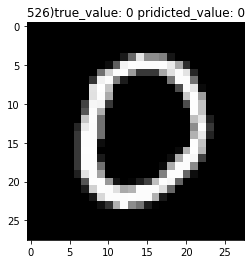

0


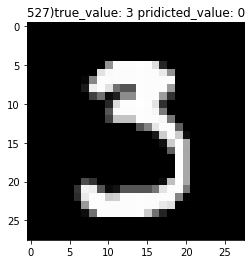

5


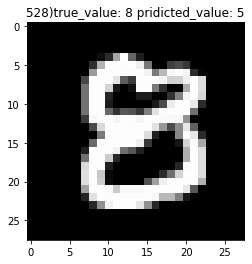

5


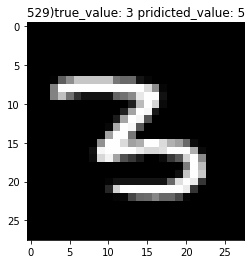

2


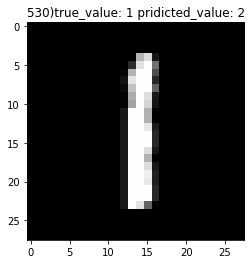

2


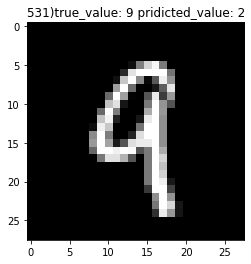

2


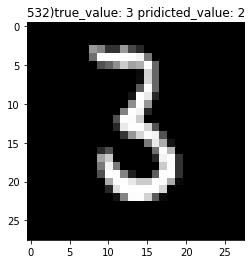

6


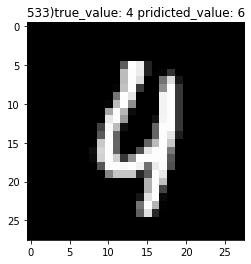

0


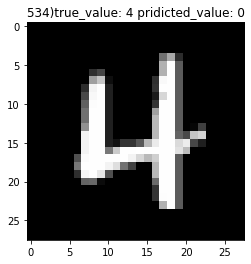

0


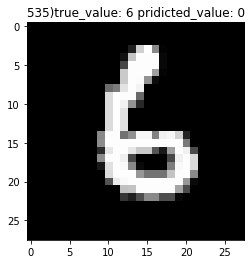

7


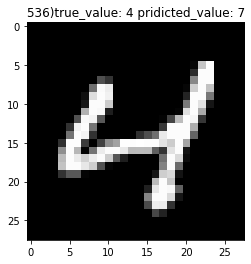

5


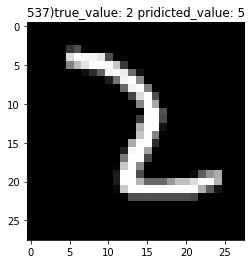

5


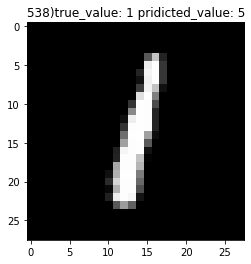

6


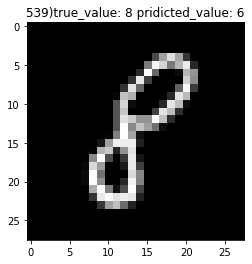

0


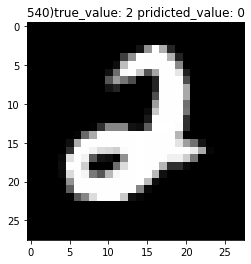

6


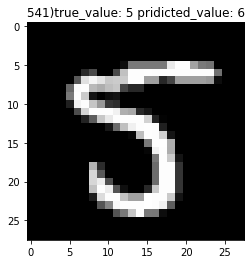

7


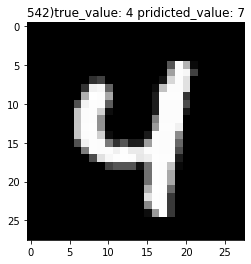

0


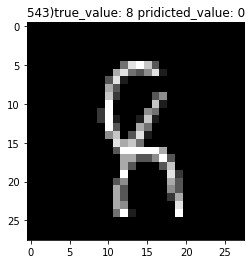

2


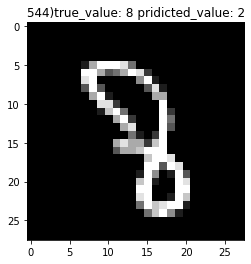

5


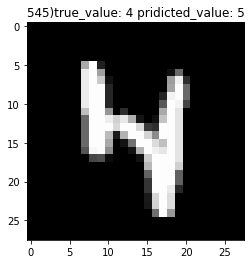

7


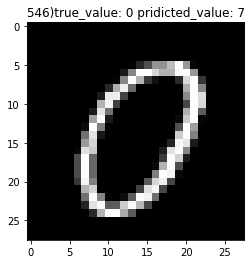

6


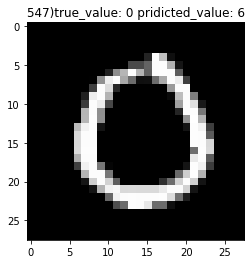

2


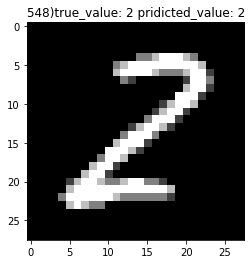

0


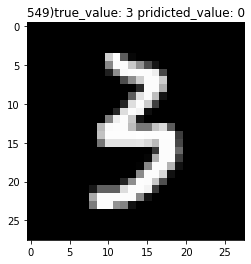

0


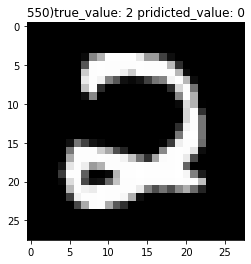

0


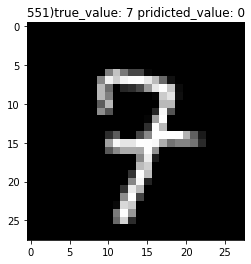

5


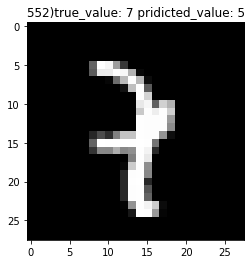

2


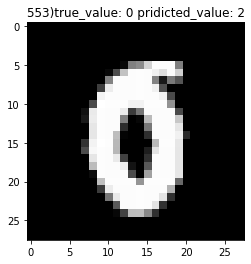

0


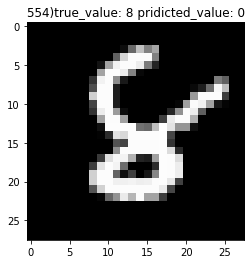

0


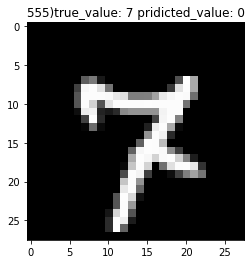

6


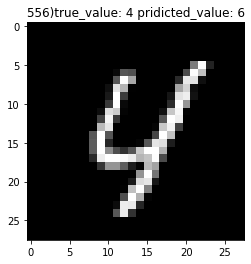

7


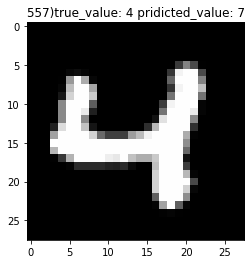

0


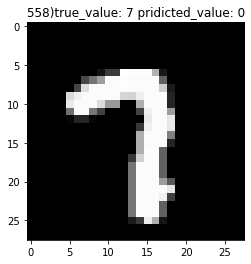

2


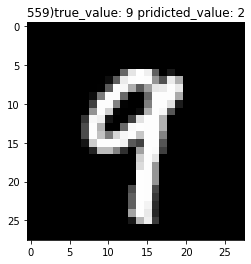

0


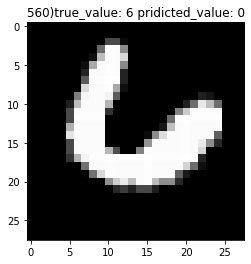

0


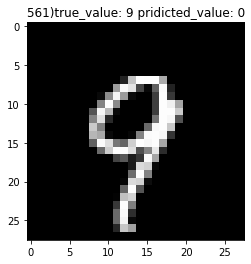

4


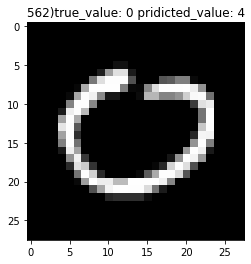

0


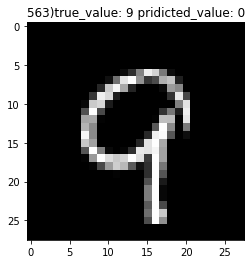

6


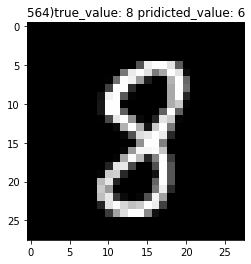

2


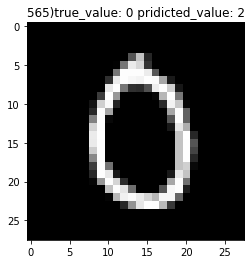

0


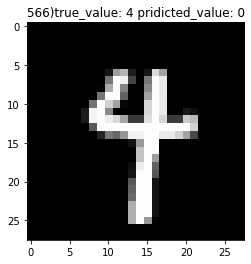

6


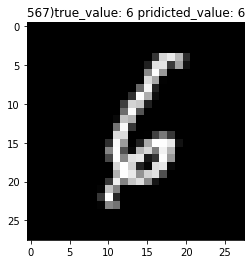

0


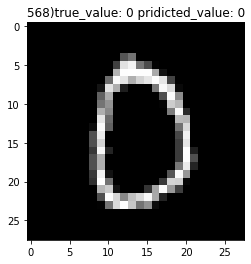

0


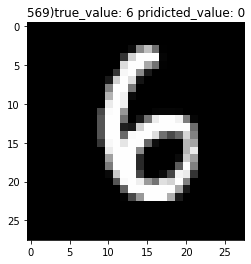

5


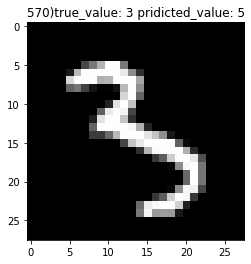

6


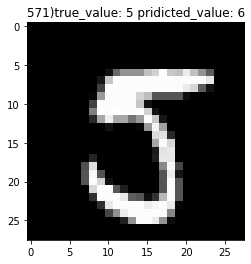

2


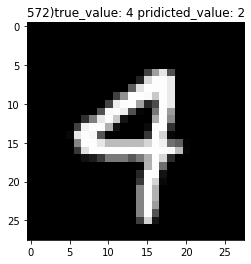

6


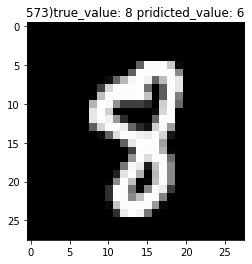

0


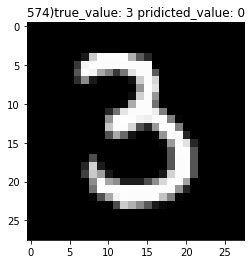

5


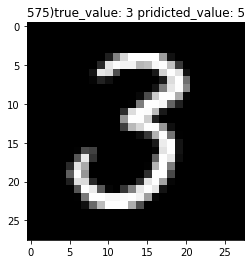

2


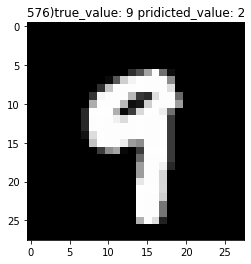

5


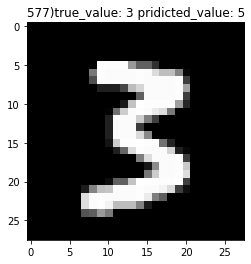

0


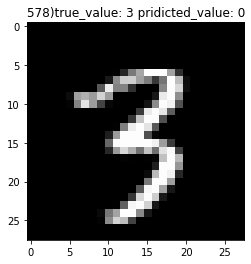

0


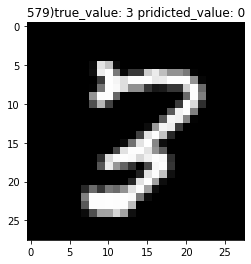

6


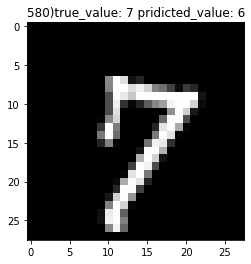

6


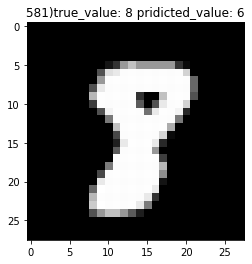

0


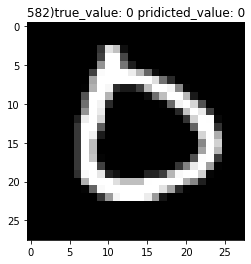

5


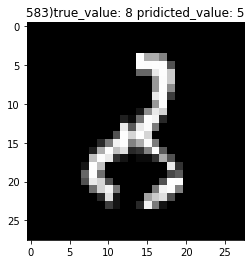

0


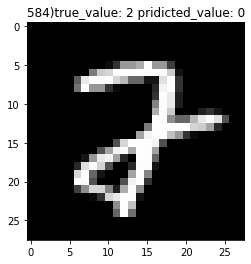

2


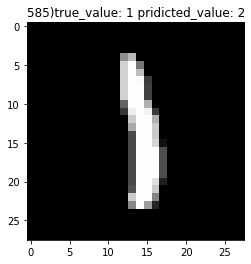

0


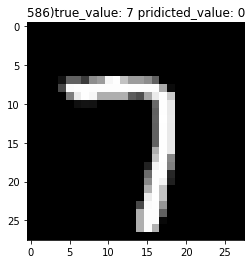

0


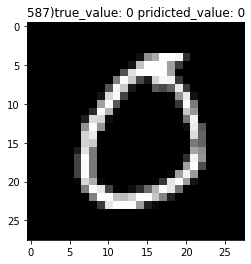

0


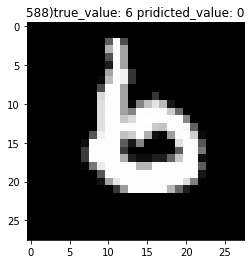

5


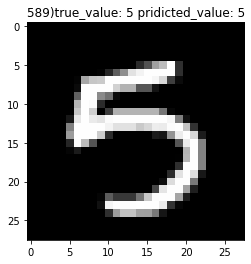

0


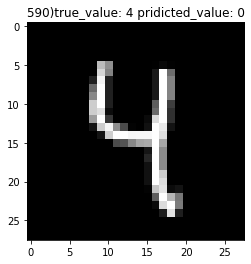

5


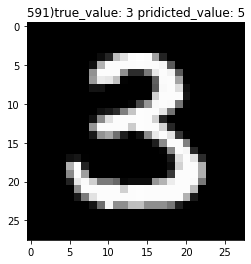

5


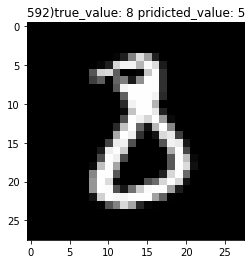

0


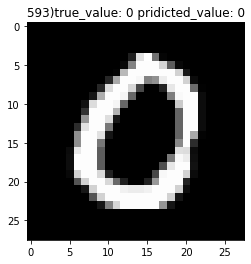

0


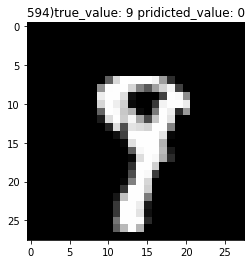

6


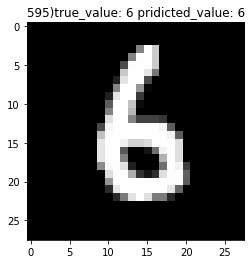

5


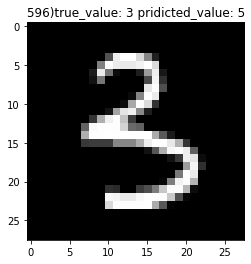

6


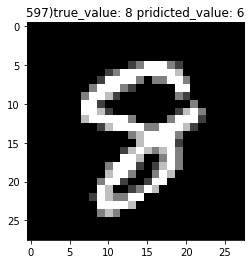

7


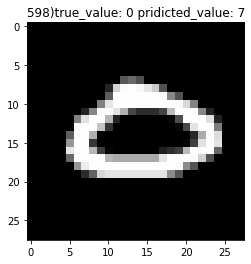

0


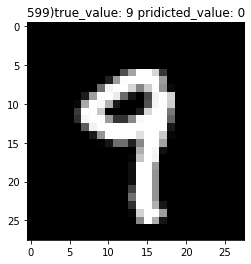

2


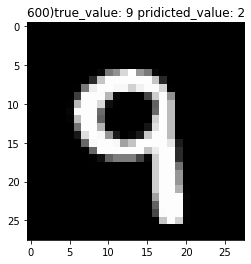

0


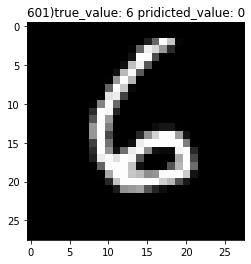

7


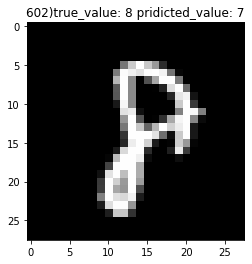

0


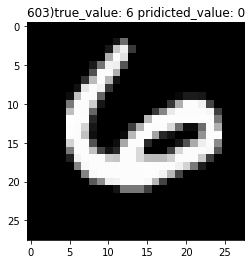

6


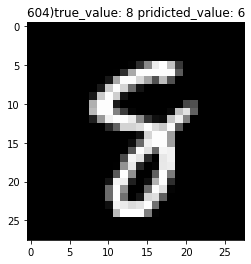

6


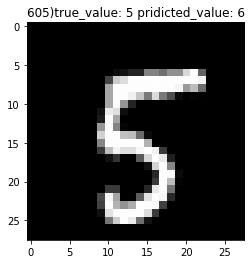

6


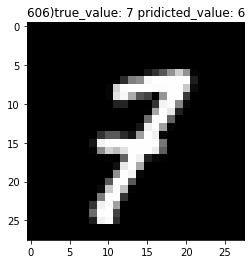

0


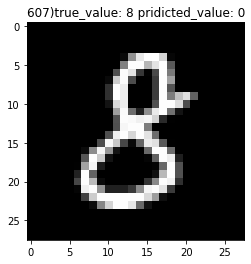

0


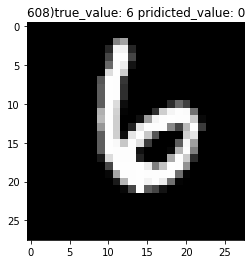

5


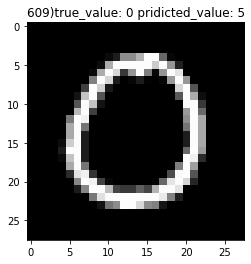

0


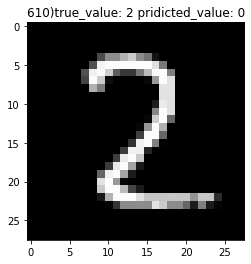

0


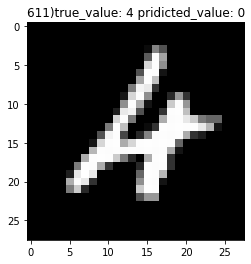

4


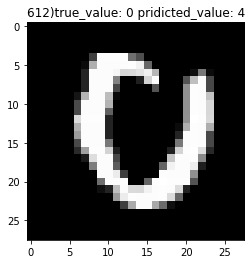

2


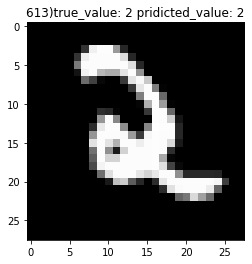

6


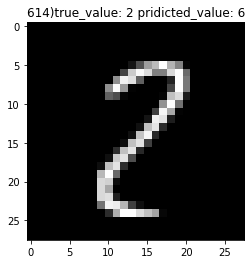

5


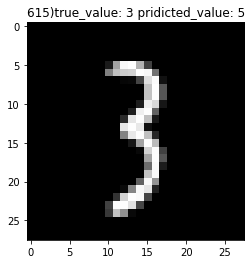

5


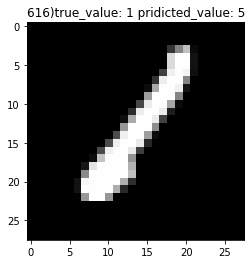

0


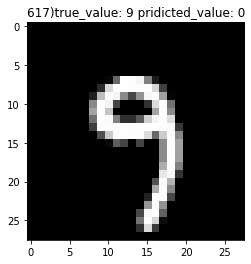

0


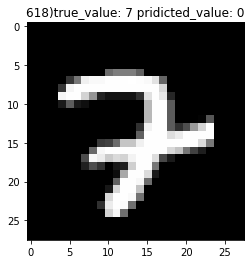

0


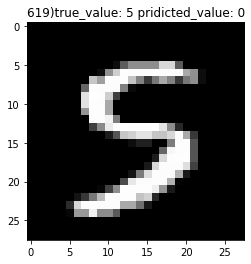

5


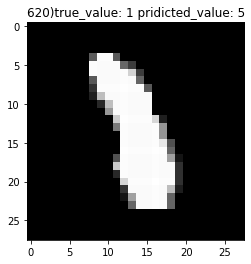

0


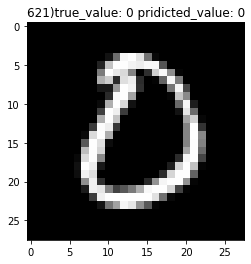

0


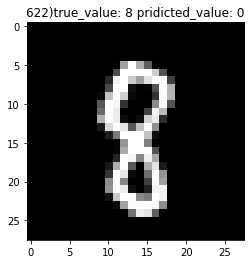

2


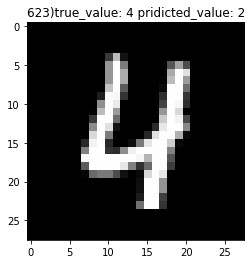

6


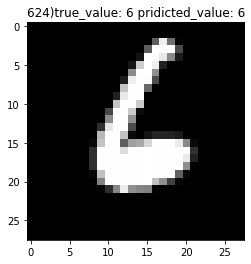

0


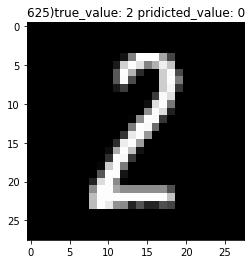

0


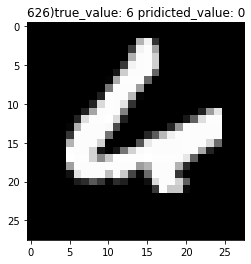

0


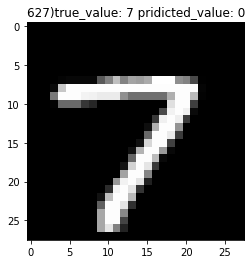

2


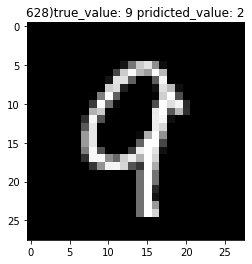

5


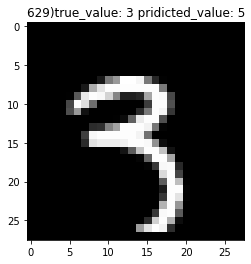

6


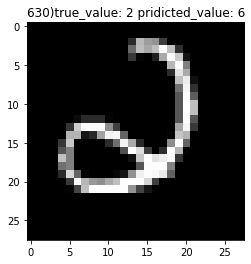

6


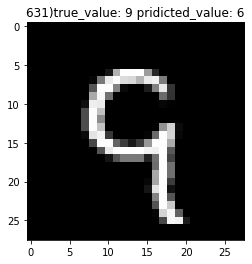

4


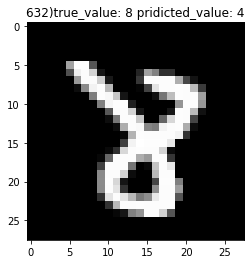

0


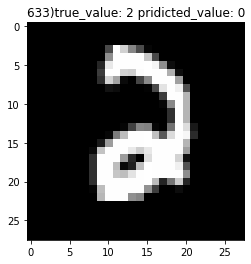

0


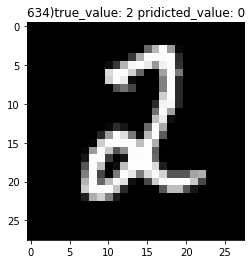

4


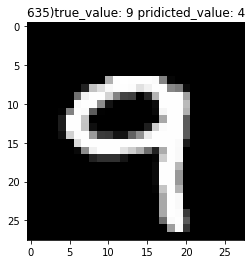

5


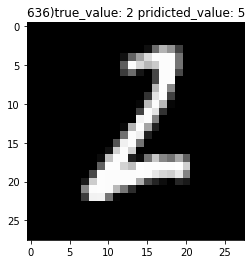

0


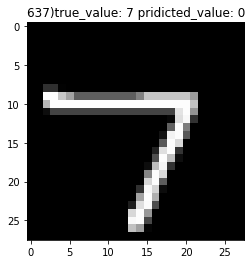

0


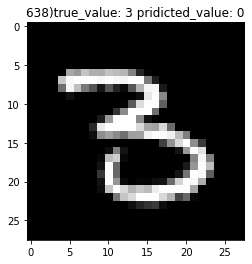

6


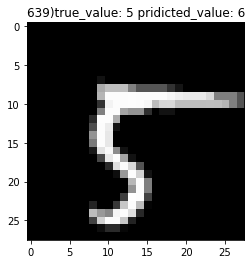

2


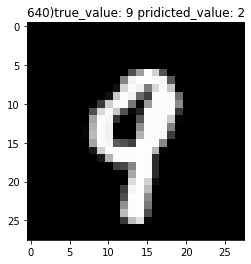

2


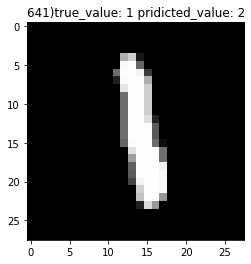

6


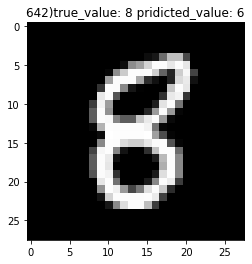

0


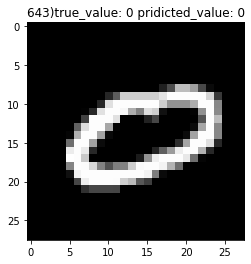

0


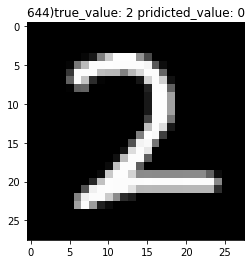

0


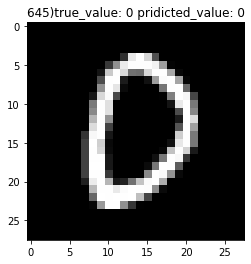

0


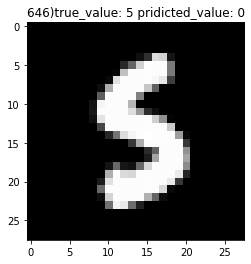

5


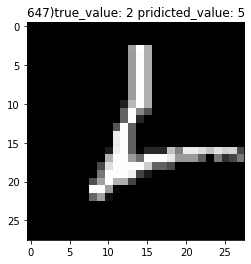

2


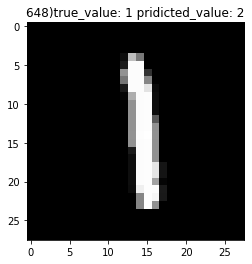

0


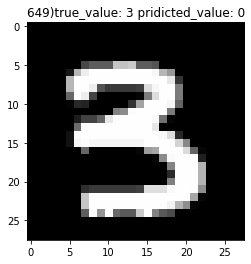

0


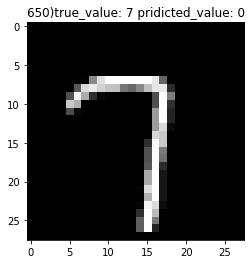

6


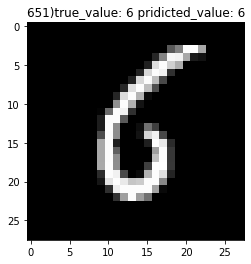

2


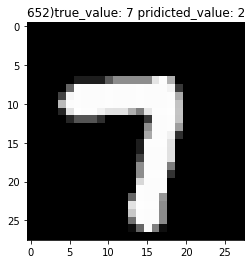

2


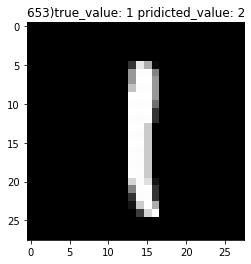

2


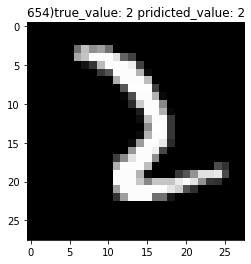

5


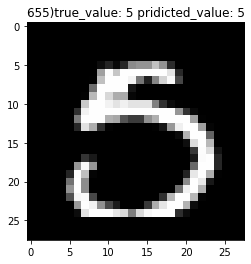

2


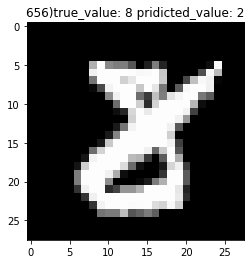

5


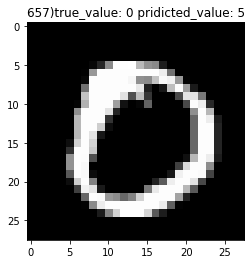

0


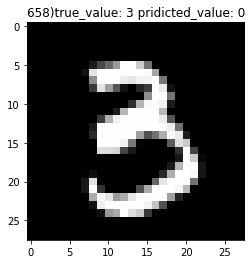

7


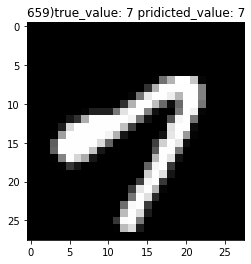

2


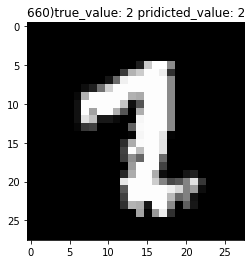

6


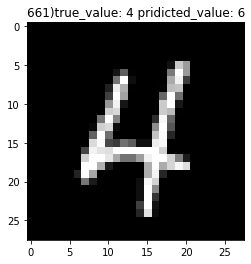

6


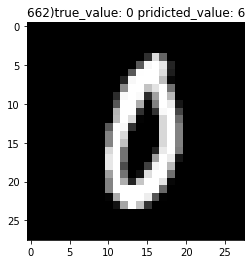

2


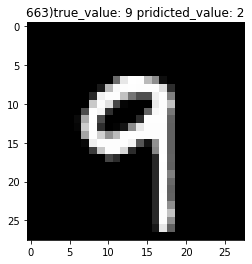

5


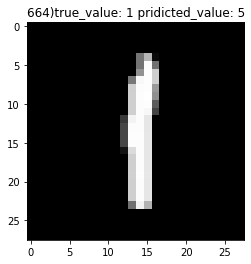

5


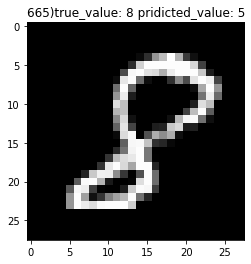

0


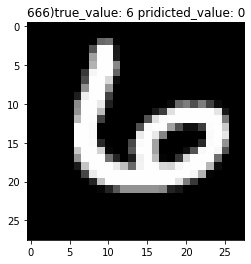

0


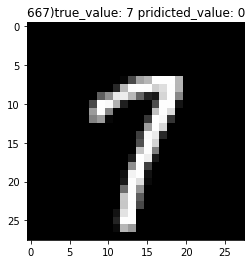

2


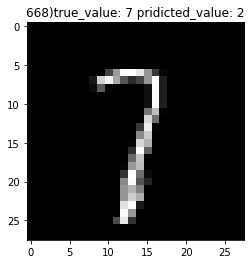

0


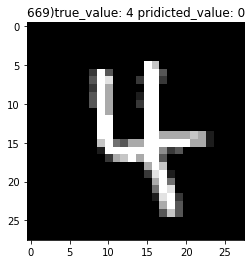

5


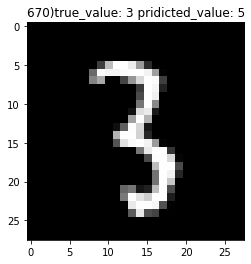

0


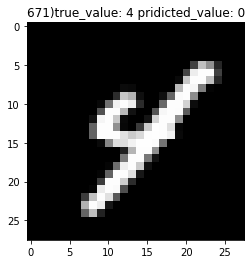

0


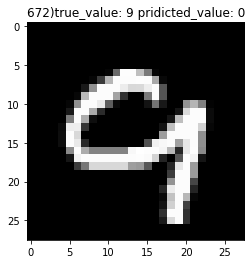

5


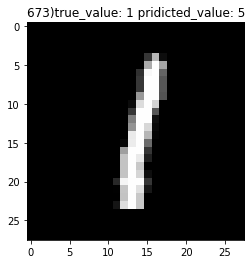

6


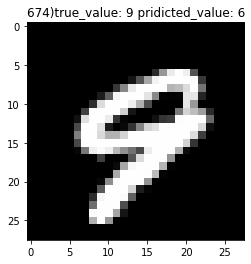

0


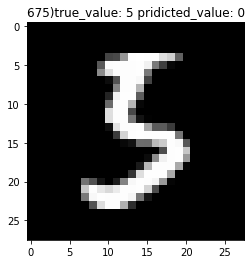

2


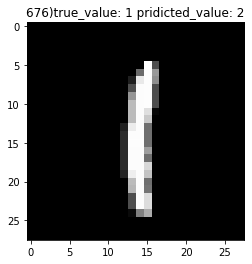

6


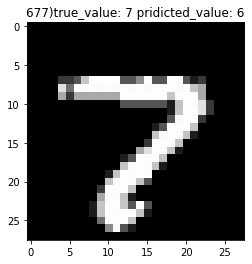

5


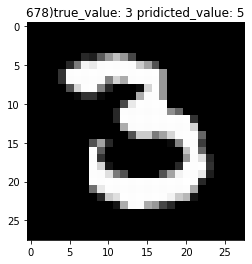

0


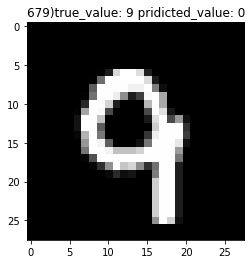

0


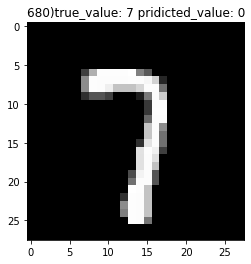

0


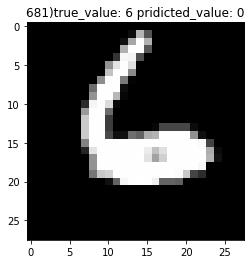

7


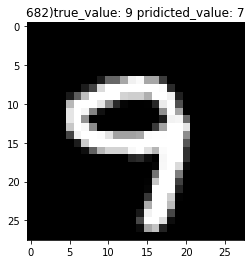

2


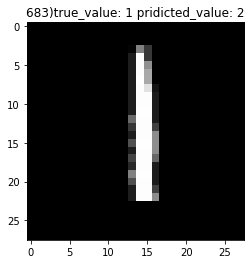

0


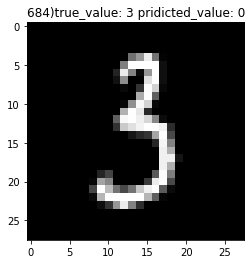

0


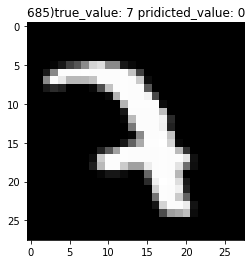

6


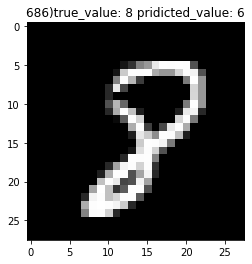

5


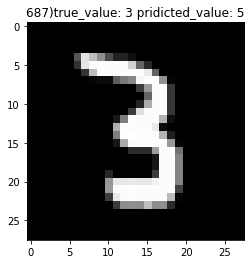

5


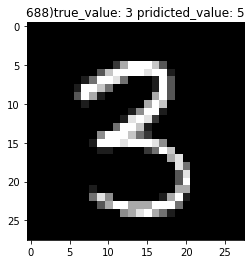

6


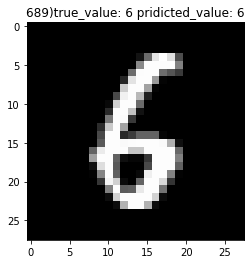

0


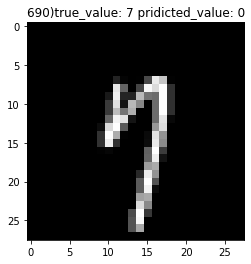

6


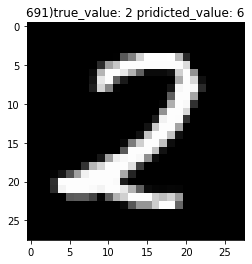

5


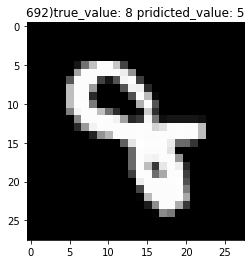

6


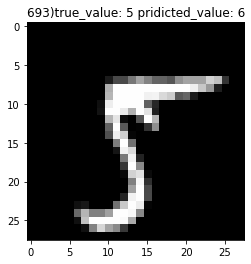

0


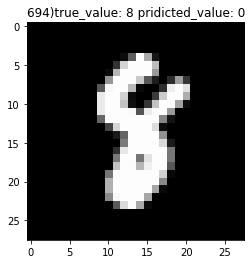

1


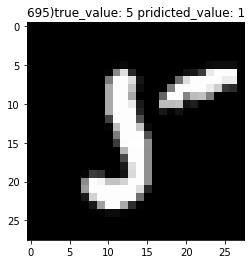

5


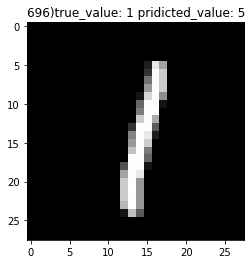

2


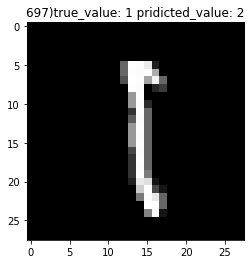

0


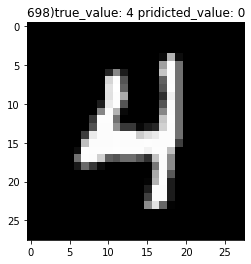

7


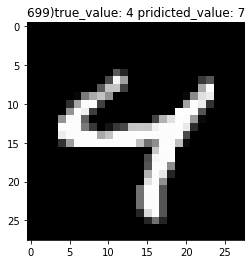

2


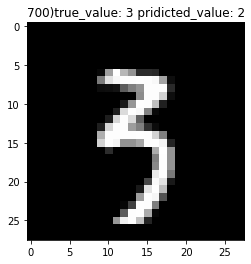

5


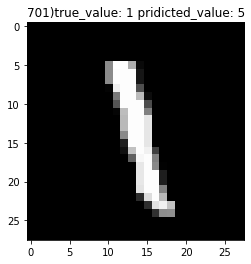

7


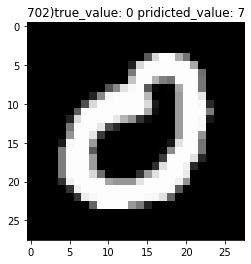

0


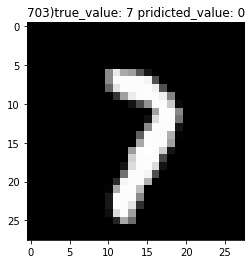

0


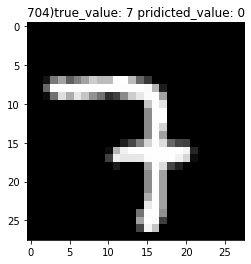

6


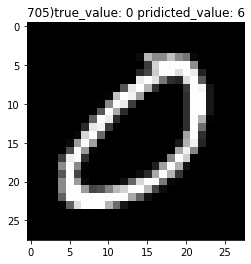

0


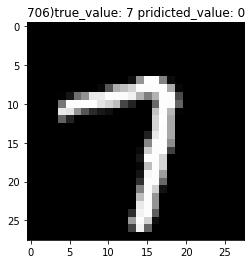

0


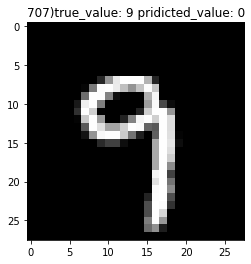

2


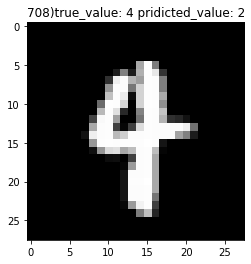

5


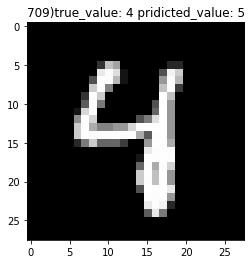

2


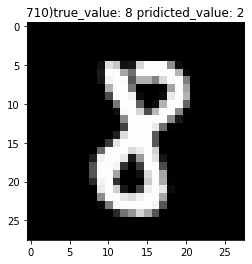

6


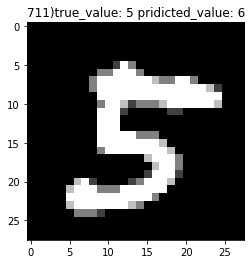

5


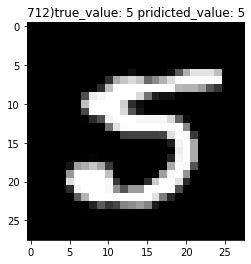

2


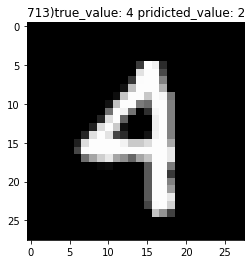

0


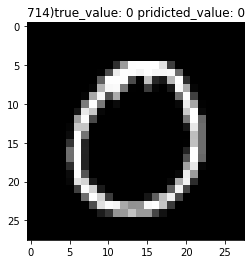

0


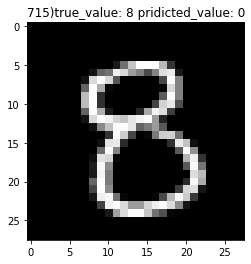

2


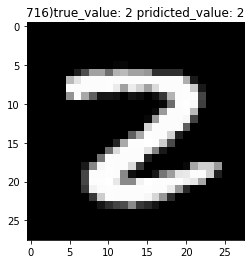

5


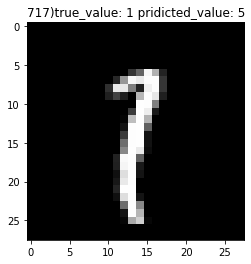

2


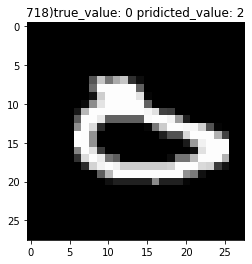

0


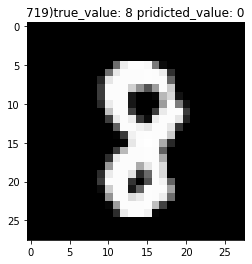

5


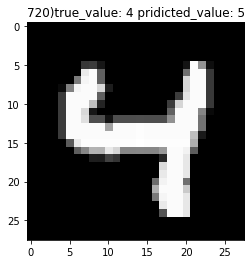

5


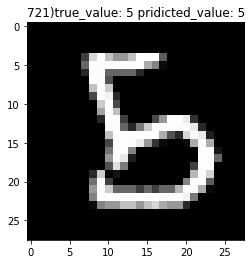

5


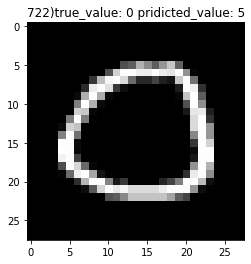

7


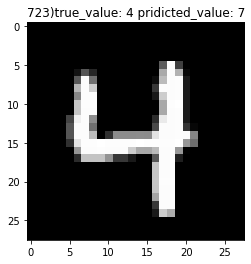

0


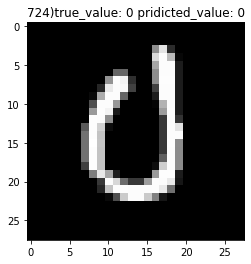

0


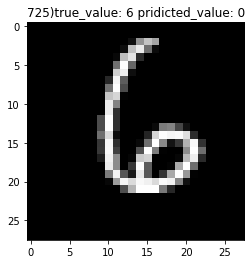

5


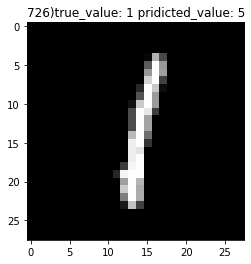

0


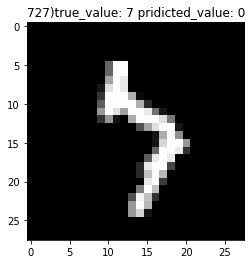

5


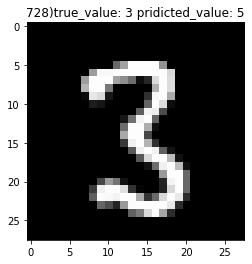

2


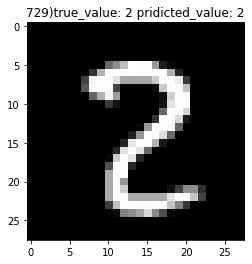

0


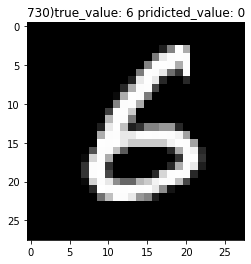

7


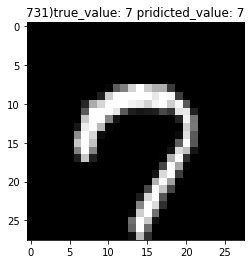

0


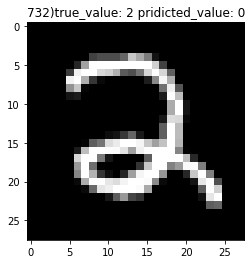

0


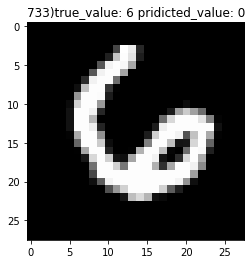

2


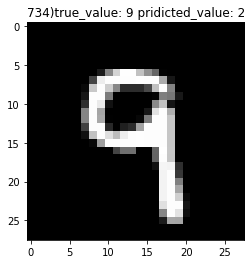

5


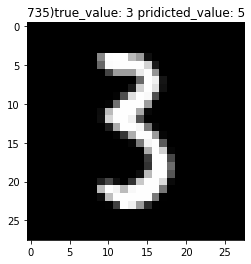

2


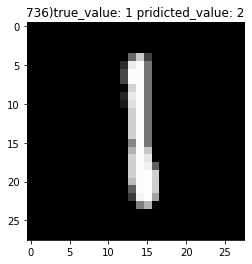

0


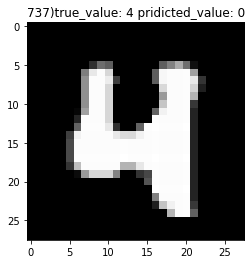

0


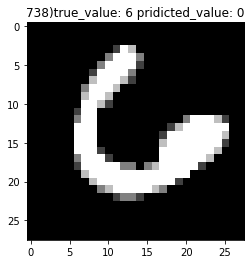

5


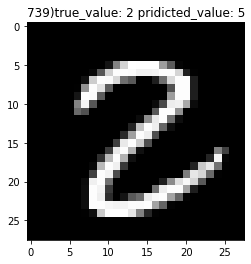

6


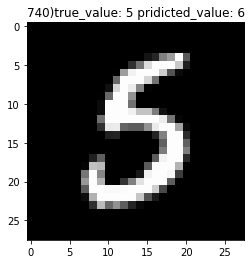

4


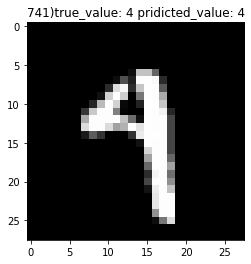

0


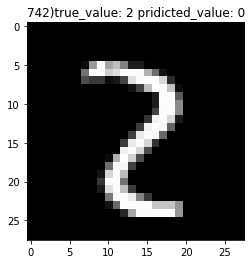

0


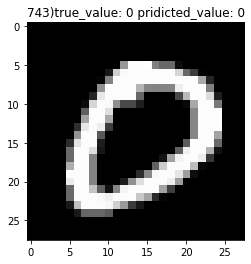

6


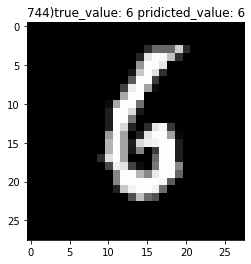

5


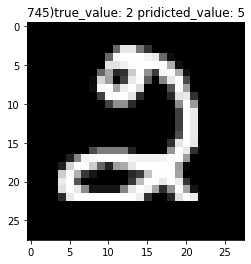

0


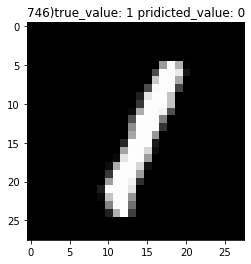

0


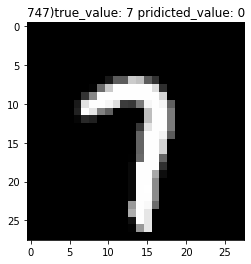

0


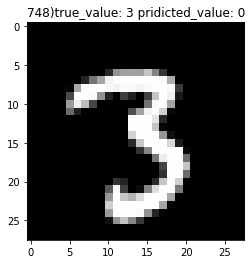

2


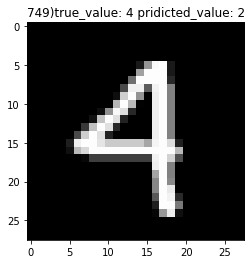

5


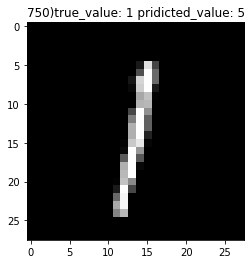

0


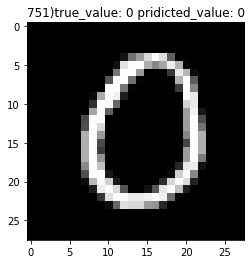

5


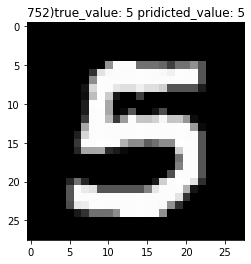

6


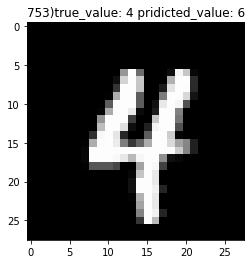

0


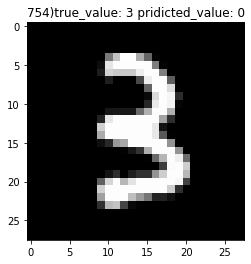

5


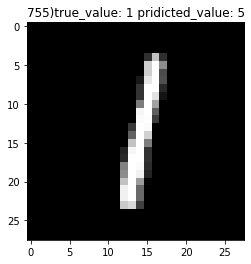

2


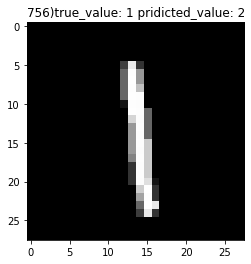

0


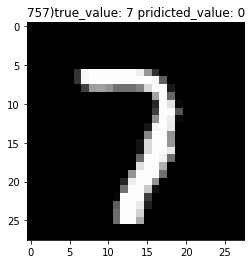

2


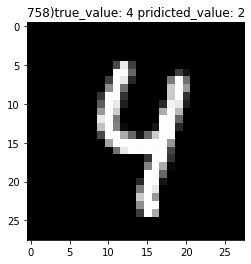

2


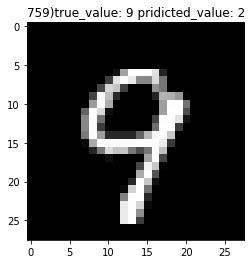

0


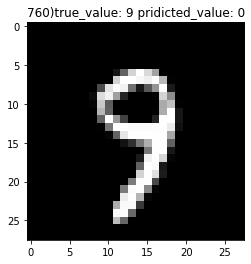

2


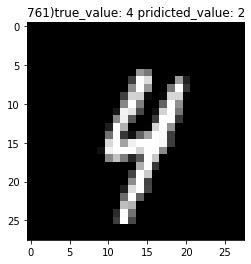

6


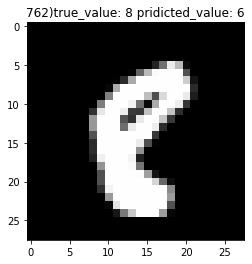

4


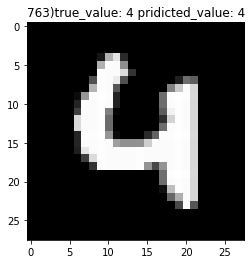

4


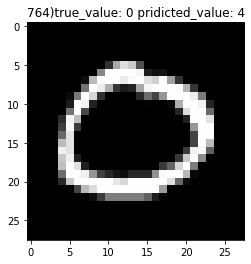

0


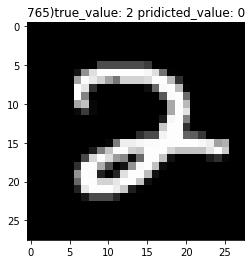

2


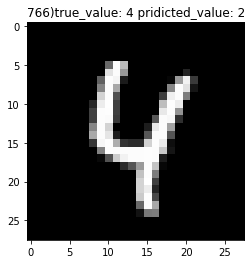

5


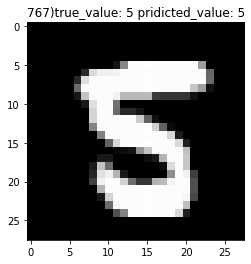

0


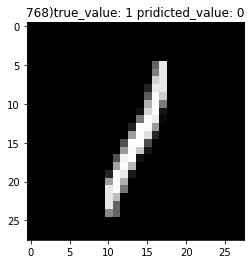

5


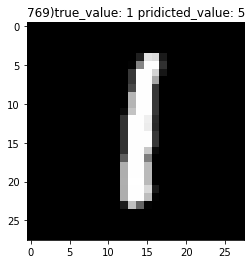

6


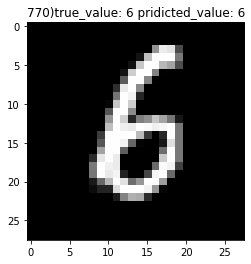

7


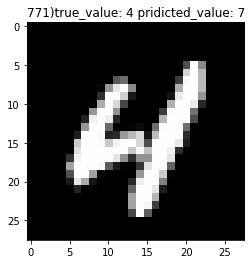

0


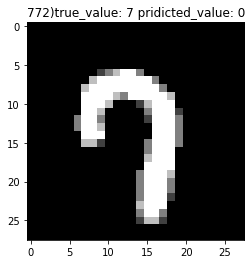

2


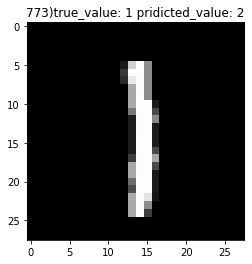

2


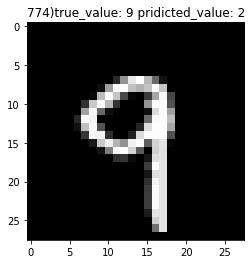

0


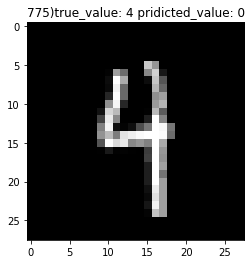

0


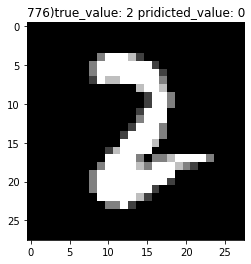

0


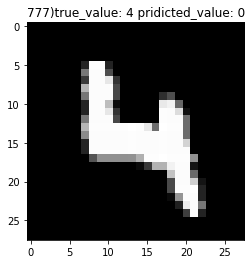

5


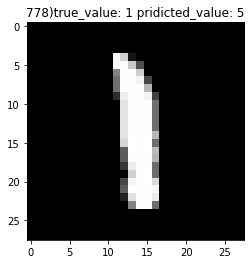

0


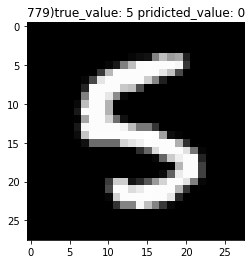

6


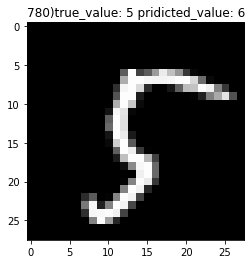

5


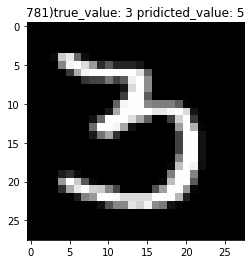

5


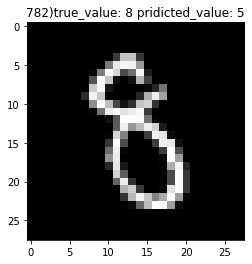

0


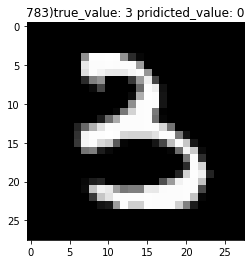

2


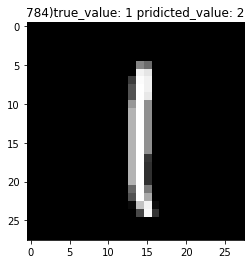

5


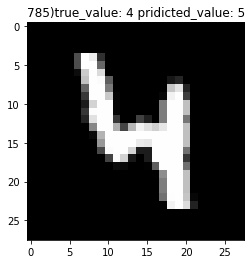

0


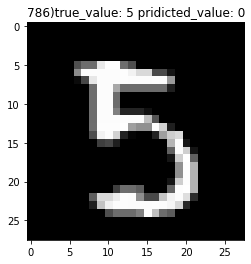

2


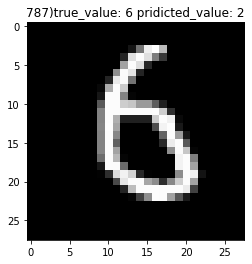

2


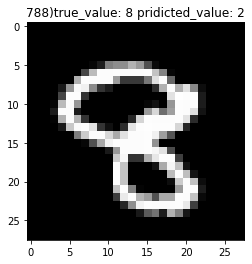

2


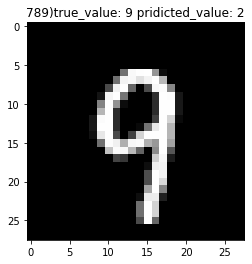

2


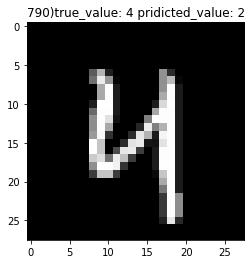

5


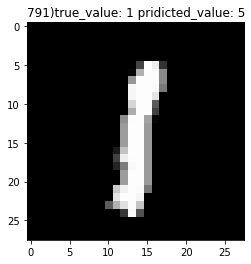

5


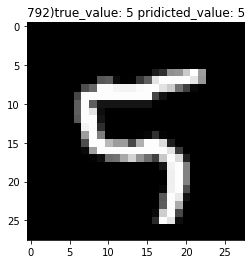

0


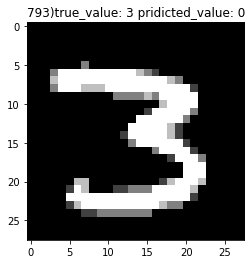

0


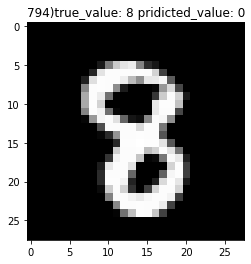

6


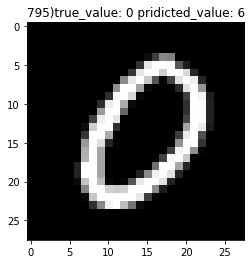

2


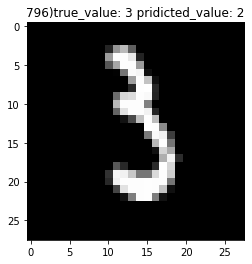

0


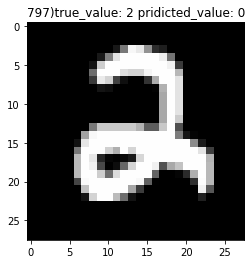

5


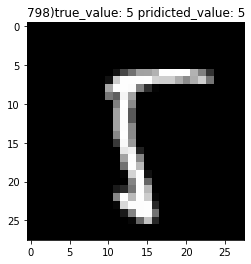

5


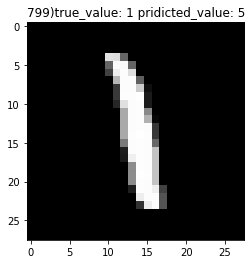

2


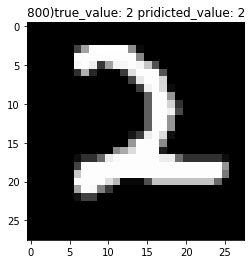

0


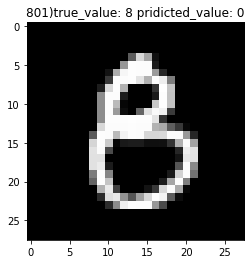

5


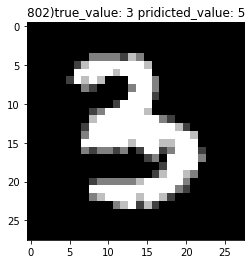

6


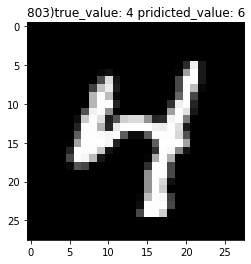

4


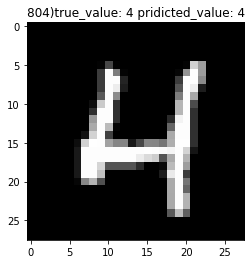

4


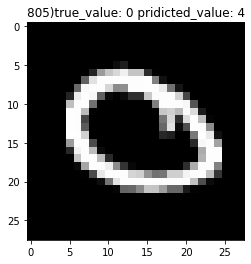

0


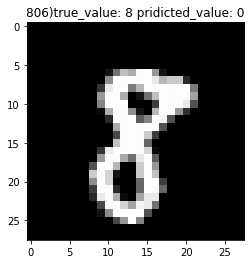

5


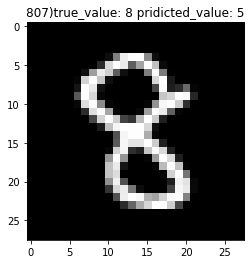

5


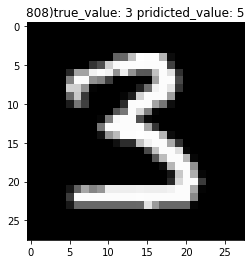

5


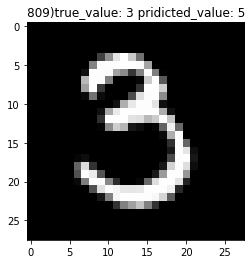

2


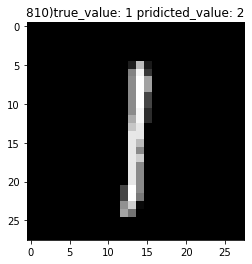

6


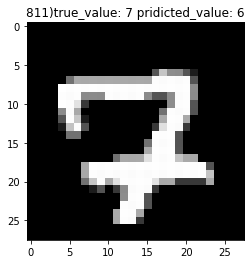

0


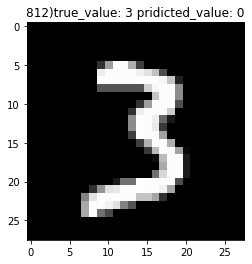

6


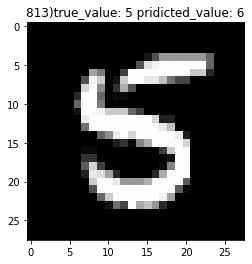

6


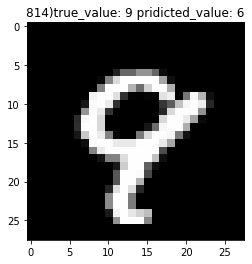

6


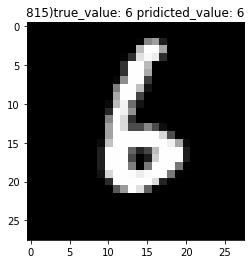

2


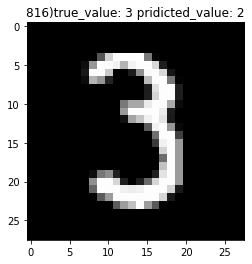

5


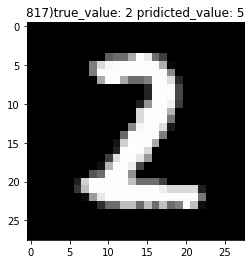

0


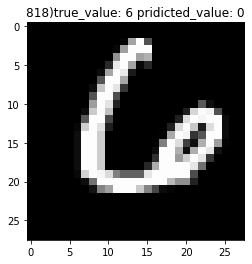

5


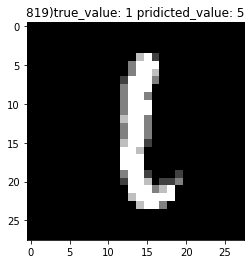

0


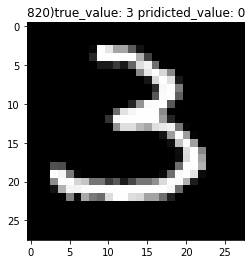

0


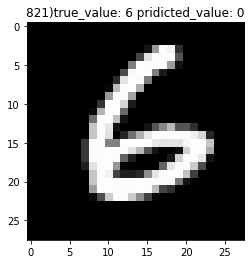

7


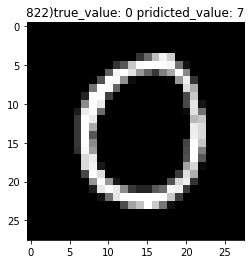

0


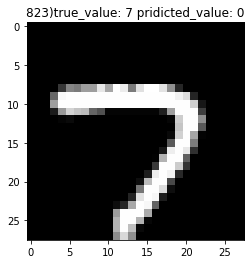

6


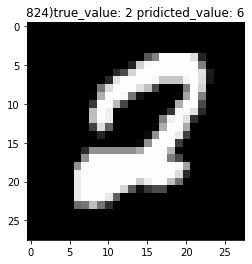

5


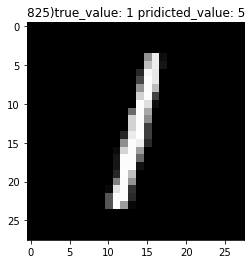

0


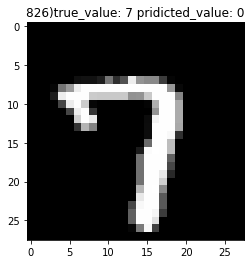

5


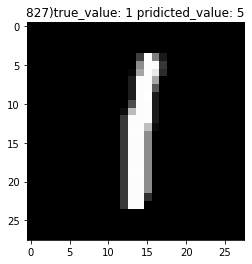

4


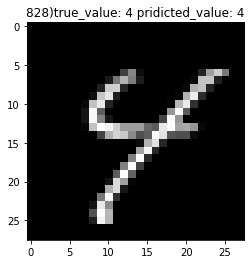

0


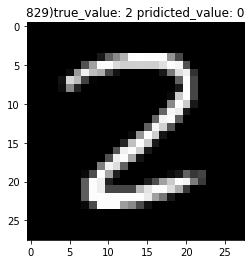

7


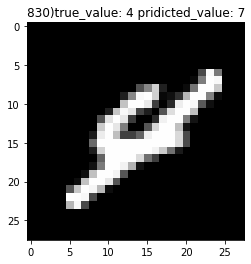

2


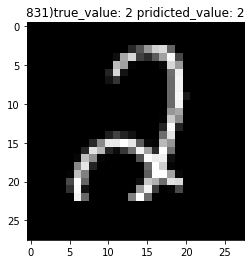

5


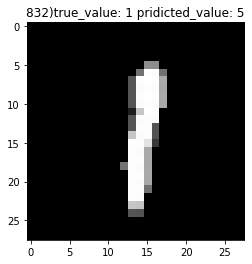

0


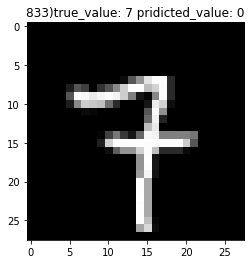

0


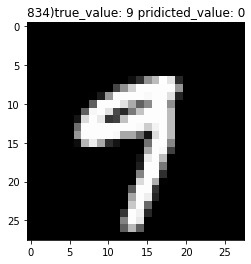

5


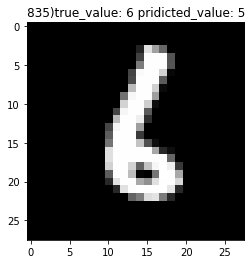

5


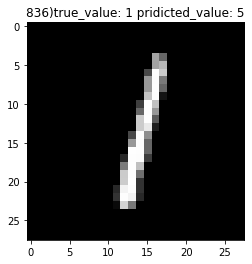

4


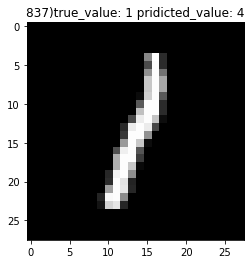

0


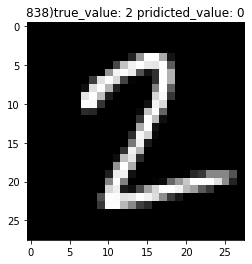

2


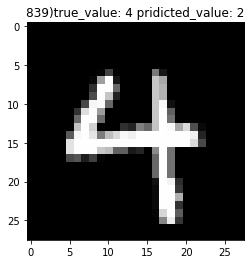

5


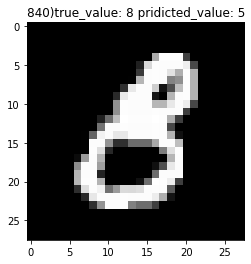

0


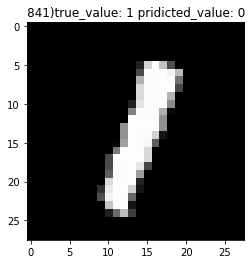

5


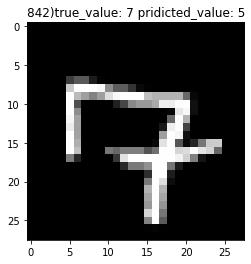

0


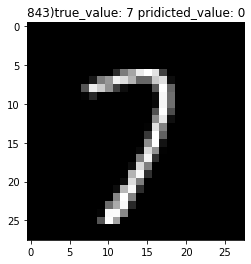

2


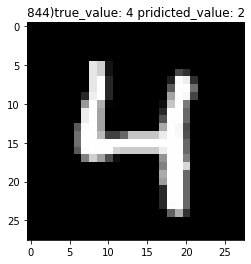

0


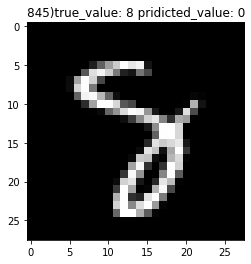

7


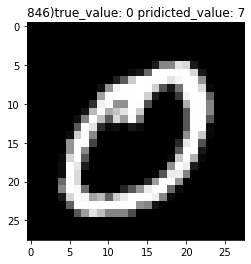

4


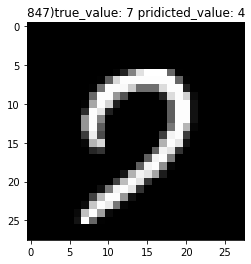

5


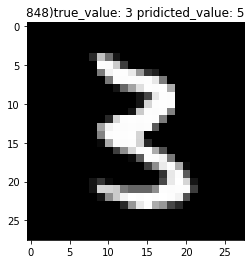

5


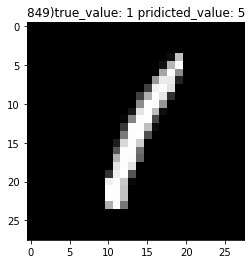

0


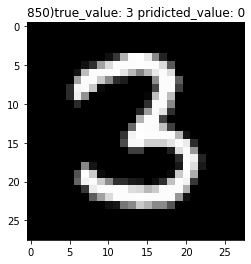

5


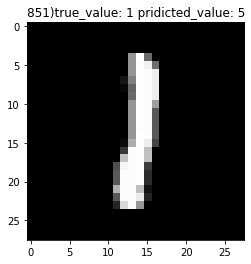

6


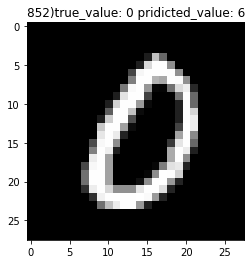

6


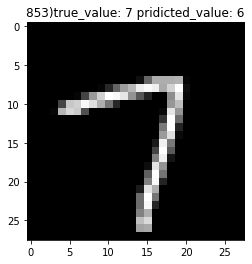

0


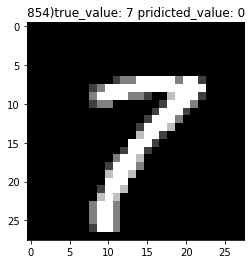

4


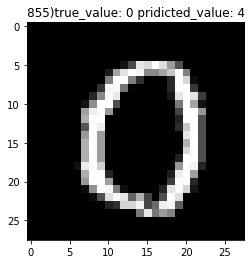

5


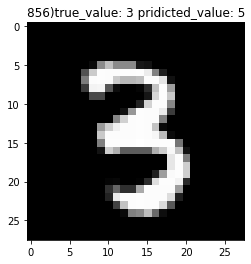

6


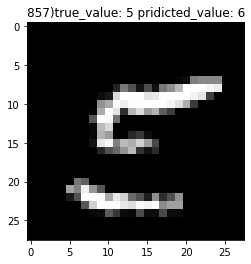

5


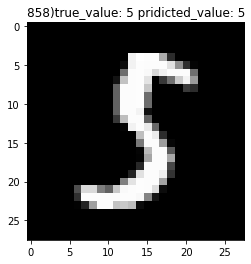

0


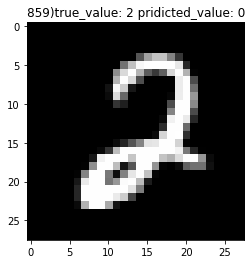

0


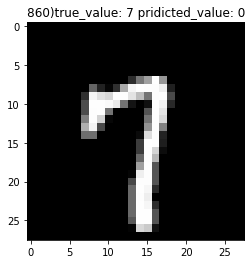

0


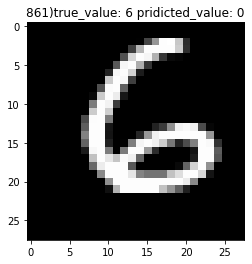

0


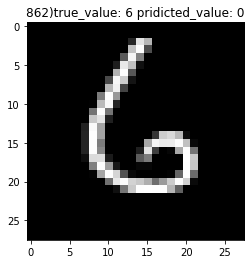

2


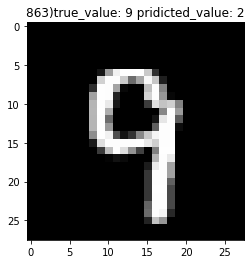

0


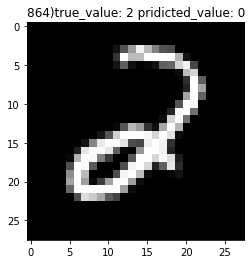

5


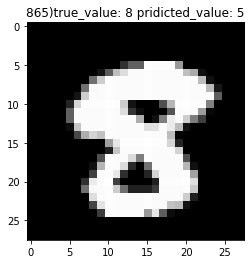

2


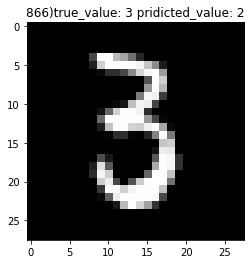

5


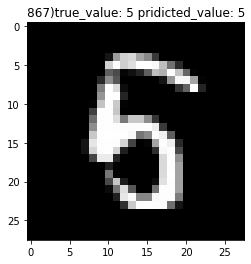

5


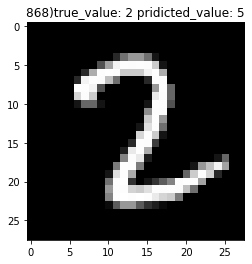

0


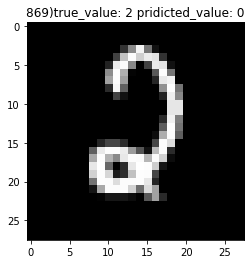

6


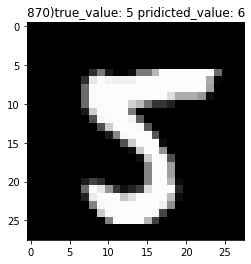

6


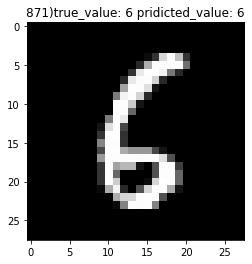

6


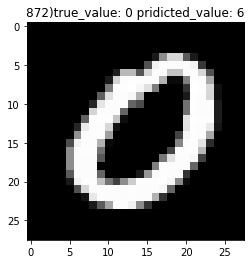

0


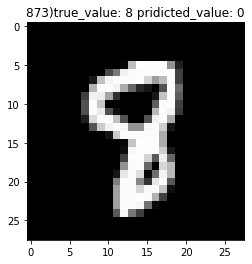

0


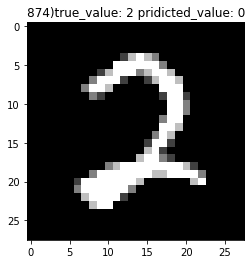

0


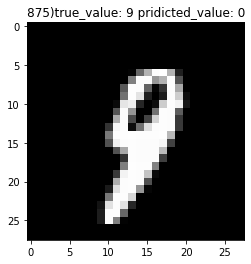

5


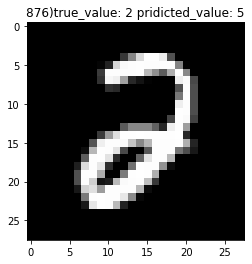

0


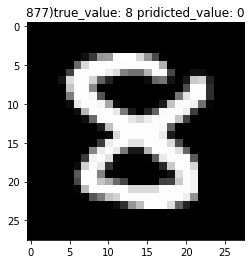

2


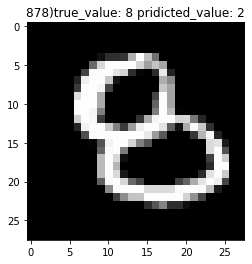

5


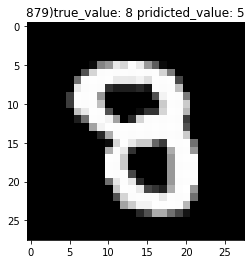

5


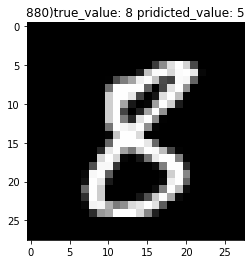

0


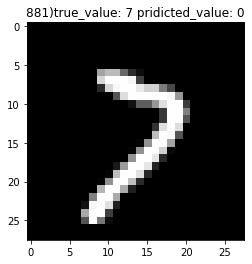

5


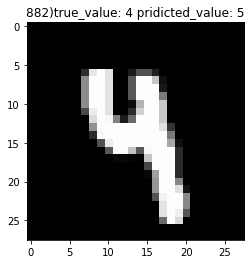

2


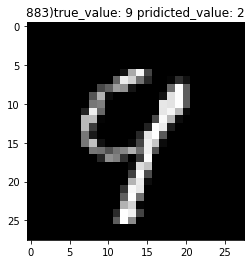

5


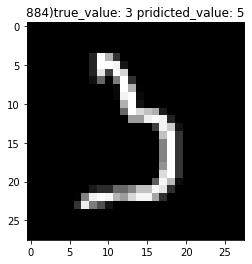

5


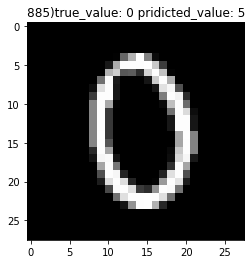

0


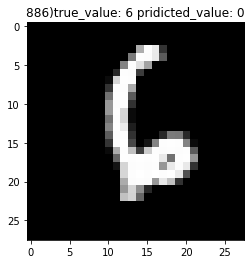

0


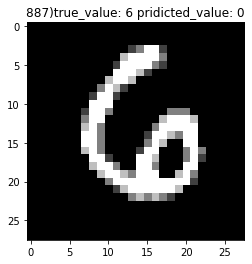

0


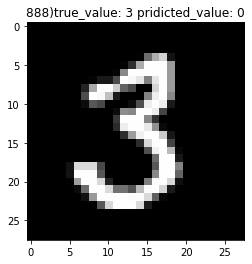

0


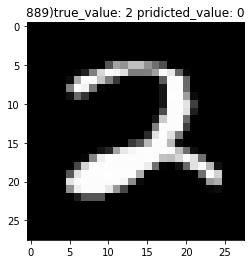

2


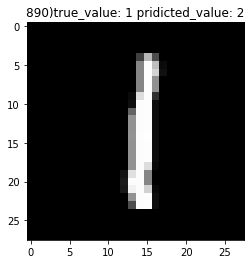

5


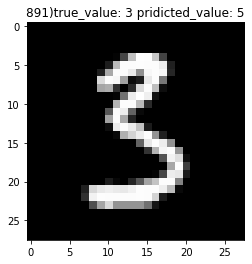

0


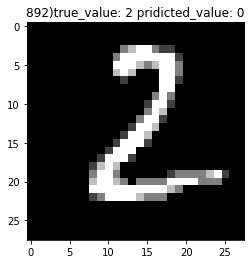

0


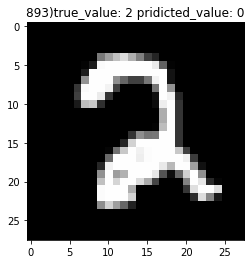

0


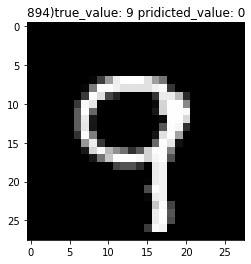

5


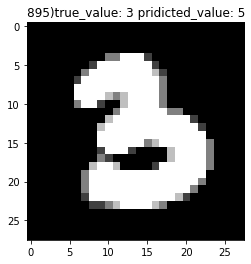

0


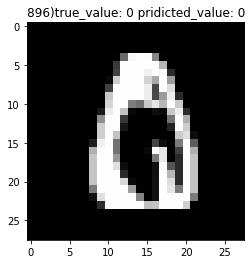

3


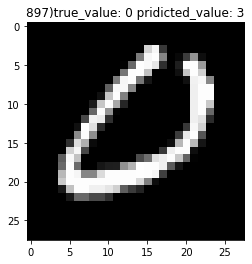

6


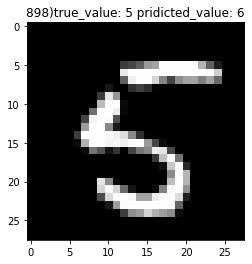

5


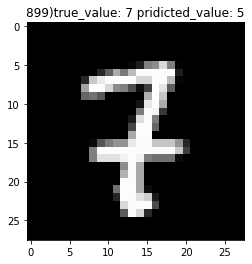

5


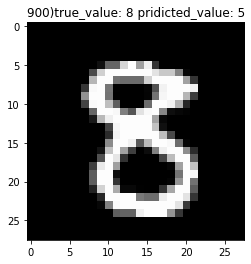

5


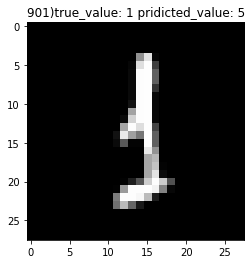

5


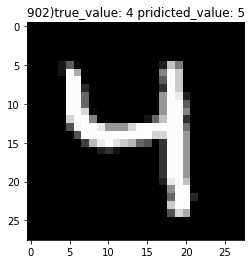

0


In [ ]:
result=mine.test(X_test,y_test,w,b)
result

In [62]:
#result = pd.DataFrame(lr_grid.cv_results_)
#result.to_csv("cv_result_유현상.csv")